In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/jw3514/Work/CellType_Psy/src')
from CellType_PSY import *
#import scanpy as sc
HGNC, ENSID2Entrez, GeneSymbol2Entrez, Entrez2Symbol = LoadGeneINFO()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
CT_Z2_MAT_HC = pd.read_csv("../dat/HumanCTExpressionMats/Human.CT.Exp.Entrez.log2.Z2.HCT.z1clip3.csv", index_col=0)
max_Z, min_Z = 3, -3
CT_Z2_MAT_HC = CT_Z2_MAT_HC.clip(upper=max_Z, lower=min_Z)
ExpZ2Mat = pd.read_csv("../../ASD_Circuits/dat/allen-mouse-exp/AllenMouseBrain_Z2bias.csv", index_col=0)
CT_Z2_MAT_HC.columns = [int(x) for x in CT_Z2_MAT_HC.columns.values]

In [4]:
ExAC_pLI = pd.read_csv("/home/jw3514/Work/Resources/gnomad.v2.1.1.lof_metrics.by_gene.txt", sep="\t",
                      index_col="gene")
ExAC_pLI.head(2)

transcript  obs_mis  exp_mis   oe_mis    mu_mis  possible_mis  \
gene                                                                        
MED13  ENST00000397786      871   1117.8  0.77921  0.000056         14195   
NIPBL  ENST00000282516      846   1441.5  0.58688  0.000074         18540   

       obs_mis_pphen  exp_mis_pphen  oe_mis_pphen  possible_mis_pphen  ...  \
gene                                                                   ...   
MED13          314.0         529.75       0.59273              6708.0  ...   
NIPBL          158.0         543.10       0.29092              7135.0  ...   

            gene_type  gene_length  exac_pLI  exac_obs_lof  exac_exp_lof  \
gene                                                                       
MED13  protein_coding       122678       1.0           0.0        64.393   
NIPBL  protein_coding       189655       1.0           1.0       110.570   

       exac_oe_lof  brain_expression  chromosome  start_position  end_position  
gene                                                                            
MED13     0.000000               NaN          17        60019966      60142643  
NIPBL     0.009044               NaN           5        36876861      37066515  

[2 rows x 76 columns]

# SCZ

In [393]:
GeneDF = pd.read_excel("/home/jw3514/Work/ASD_Circuits/dat/genes/scz/41586_2022_4556_MOESM3_ESM.xlsx",
                    sheet_name="Table S5 - Gene Results")
ExAC_pLI = pd.read_csv("/home/jw3514/Work/Resources/gnomad.v2.1.1.lof_metrics.by_gene.txt", sep="\t",
                      index_col="gene")

In [394]:
def oddsratio(NcaseMut, NctrlMut, dnvCount, Ncase = 24248, Nctrl=97322):
    if dnvCount!=dnvCount:
        dnvCount = 0
    NcaseMut += 1
    NctrlMut += 1
    AD = (NcaseMut) * (Nctrl-NctrlMut) 
    BC = (NctrlMut) * (Ncase-NcaseMut)
    return AD/BC + dnvCount

def Penetrance(NcaseMut, NctrlMut, Ncase = 24248, Nctrl=97322, prevelence=0.45/100):
    NcaseMut += 1
    NctrlMut += 1
    Ntotal_ =  Ncase/prevelence
    Nctrl_ = Ntotal_ - Ncase
    NctrlMut_ = Nctrl_*(NctrlMut/Nctrl)
    #print(Nctrl_, NctrlMut_)
    p = NcaseMut/(NcaseMut+NctrlMut_)
    return p

In [395]:
Ncase = 24248
Nctrl=97322
Ncase/(Ncase + Nctrl)

0.19945710290367688

In [396]:
print(Penetrance(15, 3))
print(Penetrance(8, 1))
print(Penetrance(12, 1))
print(Penetrance(129, 466))

0.06766125880046411
0.07548052771054478
0.1054886128420013
0.005025102756081459


In [397]:
oddsratio(15, 220, 0, Ncase = 24248, Nctrl=5364196.444444444)

16.026003368477102

In [398]:
print(15 * 0.08316973132174867)
print(129 * 0.004997288346660348)

1.24754596982623
0.6446501967191849


In [399]:
print(oddsratio(15, 3, 0))
print(oddsratio(8, 1, 0))
print(oddsratio(12, 1, 0))

16.064377682403432
18.067577045257643
26.101918712605734


In [400]:
def ModifyMutCount(CaseCount, ContCount, dnvCount, CaseN=24248, ContN=97322):
    if dnvCount!=dnvCount:
        dnvCount = 0
    return max(CaseCount - ContCount / ContN * CaseN + dnvCount, 0)

for i, row in GeneDF.iterrows():
    symbol = GeneDF.loc[i, "Gene Symbol"]
    try:
        GeneDF.loc[i, "Entrez"] = int(GeneSymbol2Entrez[symbol])
    except:
        GeneDF.loc[i, "Entrez"] = None
    try:
        GeneDF.loc[i, "pLI"] = ExAC_pLI.loc[symbol, "pLI"]
    except:
        GeneDF.loc[i, "pLI"] = 0
        
    
    GeneDF.loc[i, "nLGD"] = ModifyMutCount(GeneDF.loc[i, "Case PTV"], 
                                    GeneDF.loc[i, "Ctrl PTV"], GeneDF.loc[i, "De novo PTV"]) 
    GeneDF.loc[i, "nMis3"] = ModifyMutCount(GeneDF.loc[i, "Case mis3"], 
                                    GeneDF.loc[i, "Ctrl mis3"], GeneDF.loc[i, "De novo mis3"]) 
    GeneDF.loc[i, "nMis2"] = ModifyMutCount(GeneDF.loc[i, "Case mis2"], 
                                    GeneDF.loc[i, "Ctrl mis2"], GeneDF.loc[i, "De novo mis2"]) 
    GeneDF.loc[i, "LGD_OR"] = oddsratio(GeneDF.loc[i, "Case PTV"], 
                                    GeneDF.loc[i, "Ctrl PTV"], GeneDF.loc[i, "De novo PTV"])
    GeneDF.loc[i, "Mis3_OR"] = oddsratio(GeneDF.loc[i, "Case mis3"], 
                                    GeneDF.loc[i, "Ctrl mis3"], GeneDF.loc[i, "De novo mis3"])
    GeneDF.loc[i, "Mis2_OR"] = oddsratio(GeneDF.loc[i, "Case mis2"], 
                                    GeneDF.loc[i, "Ctrl mis2"], GeneDF.loc[i, "De novo mis2"])
    
    GeneDF.loc[i, "LGD_pen"] = Penetrance(GeneDF.loc[i, "Case PTV"], 
                                    GeneDF.loc[i, "Ctrl PTV"])
    GeneDF.loc[i, "Mis3_pen"] = Penetrance(GeneDF.loc[i, "Case mis3"], 
                                    GeneDF.loc[i, "Ctrl mis3"])
    GeneDF.loc[i, "Mis2_pen"] = Penetrance(GeneDF.loc[i, "Case mis2"], 
                                    GeneDF.loc[i, "Ctrl mis2"])
    
    
    
GeneDF = GeneDF.dropna(subset="Entrez")
GeneDF = GeneDF.set_index("Entrez")
GeneDF = GeneDF[GeneDF.index.isin(CT_Z2_MAT_HC.index.values)]
GeneDF.to_csv("../dat3/SCZ.ALLGENE.MutCountModified.csv")
GeneDF.shape

(17067, 40)

In [401]:
GeneDF.head(5)

Gene Symbol                                          Gene Name  \
Entrez                                                                   
9739.0       SETD1A                           SET domain containing 1A   
8454.0         CUL1                                           Cullin 1   
23039.0        XPO7                                         Exportin 7   
7204.0         TRIO        Trio Rho guanine nucleotide exchange factor   
8913.0      CACNA1G  Calcium channel, voltage-dependent, T type, al...   

         Case PTV  Ctrl PTV  Case mis3  Ctrl mis3  Case mis2  Ctrl mis2  \
Entrez                                                                    
9739.0       15.0       3.0        3.0        4.0         11         10   
8454.0        8.0       1.0        2.0        0.0          7         16   
23039.0      12.0       1.0        1.0        1.0         10         32   
7204.0       18.0      16.0        0.0        0.0         24        102   
8913.0       10.0      13.0        8.0        4.0         55        134   

         P ca/co (Class 1)  P ca/co (Class 2)  ...  pLI       nLGD     nMis3  \
Entrez                                         ...                             
9739.0        3.600000e-07           0.000588  ...  1.0  17.252543  2.003391   
8454.0        1.010000e-05           0.261000  ...  1.0  10.750848  2.000000   
23039.0       2.000000e-08           0.539000  ...  1.0  12.750848  0.750848   
7204.0        2.080000e-06           0.910000  ...  1.0  16.013563  0.000000   
8913.0        3.160000e-06           0.031700  ...  1.0   6.761020  7.003391   

             nMis2     LGD_OR    Mis3_OR   Mis2_OR   LGD_pen  Mis3_pen  \
Entrez                                                                   
9739.0    8.508477  19.064378   3.211252  4.380156  0.067661  0.014307   
8454.0    3.013563  21.067577  12.042194  1.889051  0.075481  0.051619   
23039.0   2.027126  27.101919   4.013858  1.338023  0.105489  0.017820   
7204.0    0.000000   6.488532   4.013734  0.974150  0.019874  0.017820   
8913.0   22.613592   3.154528   7.226808  2.666444  0.014055  0.031624   

         Mis2_pen  
Entrez             
9739.0   0.019408  
8454.0   0.008466  
23039.0  0.006011  
7204.0   0.004384  
8913.0   0.007470  

[5 rows x 40 columns]

In [29]:
SCZ_100GW = Aggregate_Gene_Weights_SCZ_Daly(GeneDF.head(100), CT_Z2_MAT_HC.index.values)
SCZ_200GW = Aggregate_Gene_Weights_SCZ_Daly(GeneDF.head(200), CT_Z2_MAT_HC.index.values)

343172 not in allen mouse dataset
343172 not in allen mouse dataset


In [30]:
Dict2Fil(SCZ_100GW, "../dat3/SCZ.top100.gw.csv")
Dict2Fil(SCZ_200GW, "../dat3/SCZ.top200.gw.csv")

In [46]:
GeneDF = GeneDF[GeneDF.index.isin(CT_Z2_MAT_HC.index.values)]

In [147]:
NLGDs = []
NDmis = []
Bias_CT = {}
for i, row in GeneDF.head(61).iterrows():
    try:
        gene = int(i)
        NLGDs.append(row["nLGD"])
        NDmis.append(row["nMis3"] + row["nMis2"])
        for CT in Neurons:
            CT_Idx = Anno[Anno["Supercluster"]==CT].index.values
            if CT not in Bias_CT:
                Bias_CT[CT] = []
            Bias_CT[CT].append(CT_Z2_MAT_HC.loc[gene, CT_Idx].mean())
    except:
        print(i, "not in exp data")

In [148]:
NLGDs = np.array(NLGDs)

In [149]:
print(len(NLGDs))
print(len(Bias_CT["Amygdala excitatory"]))

61
61


In [150]:
CT = "CGE interneuron"
CT = "MGE interneuron"
CT = "Thalamic excitatory"
_CT_Bias = np.array(Bias_CT[CT])
_CT_Bias > 0
NLGD_Pos = NLGDs[_CT_Bias > 0]
NLGD_Neg = NLGDs[_CT_Bias <= 0]
Total_G = len(NLGD_Pos) + len(NLGD_Neg)
print(len(NLGD_Pos), len(NLGD_Neg))
N_Mut_Pos = int(NLGD_Pos.sum())
Total_Mut = int(N_Mut_Pos + int(NLGD_Neg.sum()))
print(N_Mut_Pos, Total_Mut, N_Mut_Pos/Total_Mut / (len(NLGD_Pos)/Total_G))
print(scipy.stats.binom_test(N_Mut_Pos, Total_Mut, p=len(NLGD_Pos)/Total_G))

31 30
309 574 1.0592896481960212
0.1558059946647842


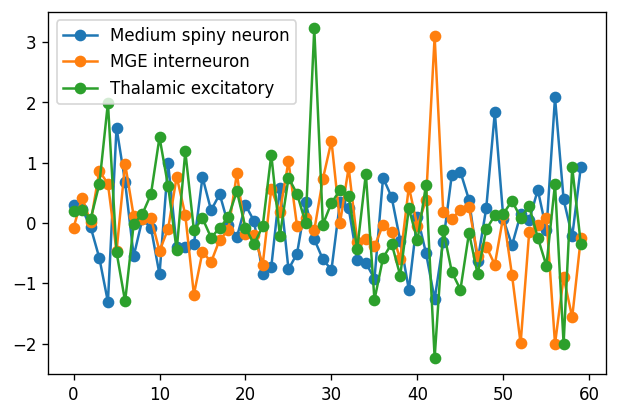

In [162]:
## Rank vs Bias
CT = "MGE interneuron"
CT = "Thalamic excitatory"
CT = "Medium spiny neuron"
CT_Idx = Anno[Anno["Supercluster"]==CT].index.values
Gene_Idx = GeneDF.head(60).index.values
dat = CT_Z2_MAT_HC.loc[Gene_Idx, CT_Idx].mean(axis=1)

fig, ax = plt.subplots(dpi=120)
CT = "Medium spiny neuron"
CT_Idx = Anno[Anno["Supercluster"]==CT].index.values
Gene_Idx = GeneDF.head(60).index.values
dat = CT_Z2_MAT_HC.loc[Gene_Idx, CT_Idx].mean(axis=1)
ax.plot(np.arange(len(Gene_Idx)), dat, marker="o", label=CT)

CT = "MGE interneuron"
CT_Idx = Anno[Anno["Supercluster"]==CT].index.values
Gene_Idx = GeneDF.head(60).index.values
dat = CT_Z2_MAT_HC.loc[Gene_Idx, CT_Idx].mean(axis=1)
ax.plot(np.arange(len(Gene_Idx)), dat, marker="o", label=CT)

CT = "Thalamic excitatory"
CT_Idx = Anno[Anno["Supercluster"]==CT].index.values
Gene_Idx = GeneDF.head(60).index.values
dat = CT_Z2_MAT_HC.loc[Gene_Idx, CT_Idx].mean(axis=1)
ax.plot(np.arange(len(Gene_Idx)), dat, marker="o", label=CT)

plt.legend()

In [152]:
NLGD_Pos

array([17.2525431 , 10.7508477 , 12.7508477 , 16.01356322,  6.76102012,
       20.02712645, 10.00339081,  8.        , 13.76102012, 13.75762931,
       13.51186782,  7.75423851,  7.76102012,  8.25932472, 10.75423851,
        7.50508621, 16.26949713,  8.25593391,  3.        , 15.01695403,
       10.26271552, 14.51864943,  6.00339081,  6.        ,  9.01017242,
        7.75762931,  6.25593391,  7.51186782,  5.00339081,  4.7508477 ,
        5.5016954 ])

Amygdala excitatory


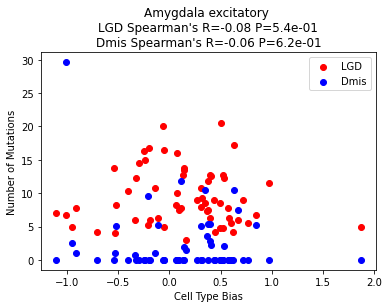

CGE interneuron


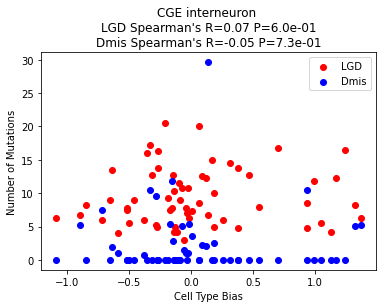

Cerebellar inhibitory


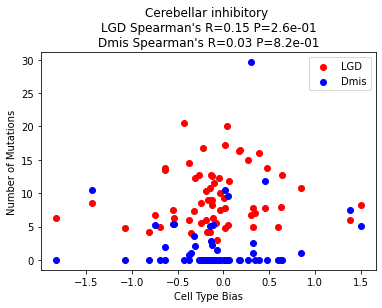

Deep-layer corticothalamic and 6b


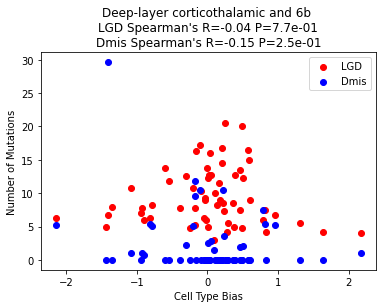

Deep-layer intratelencephalic


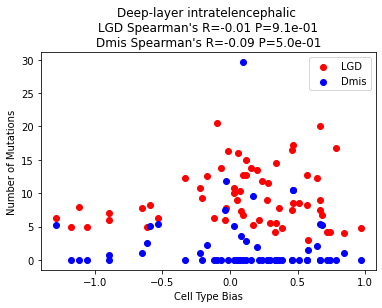

Deep-layer near-projecting


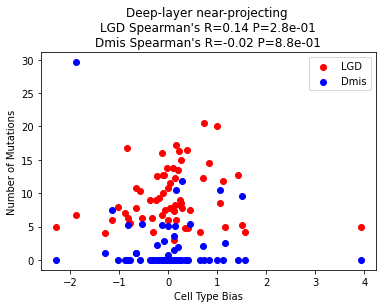

Eccentric medium spiny neuron


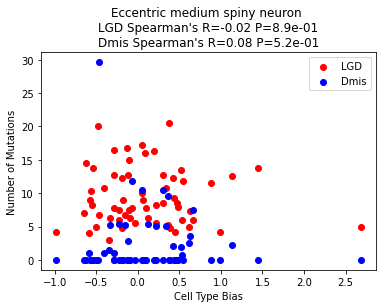

Hippocampal CA1-3


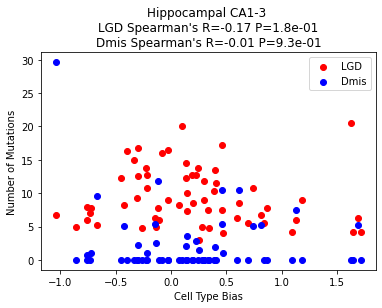

Hippocampal CA4


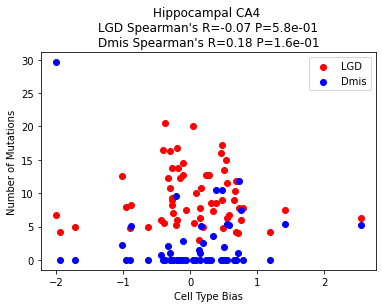

Hippocampal dentate gyrus


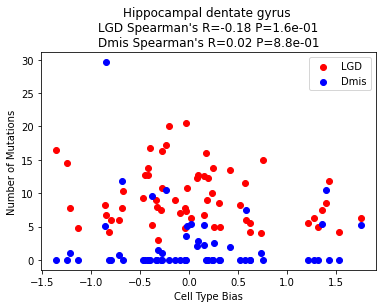

LAMP5-LHX6 and Chandelier


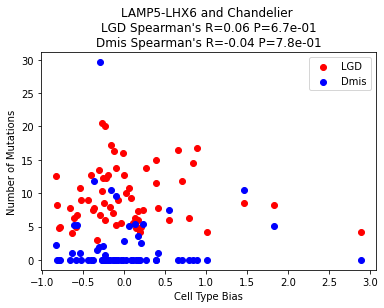

Lower rhombic lip


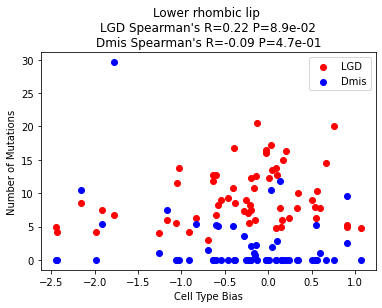

MGE interneuron


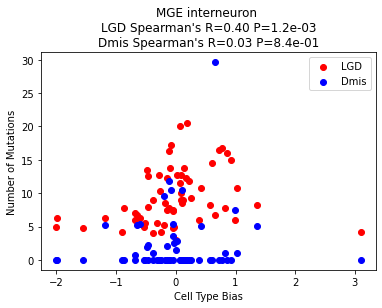

Mammillary body


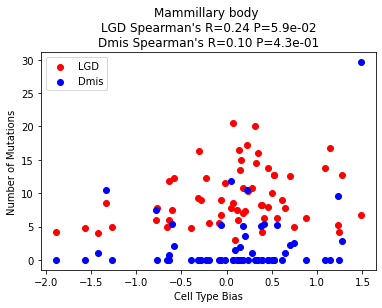

Medium spiny neuron


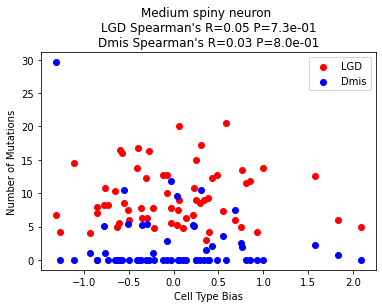

Midbrain-derived inhibitory


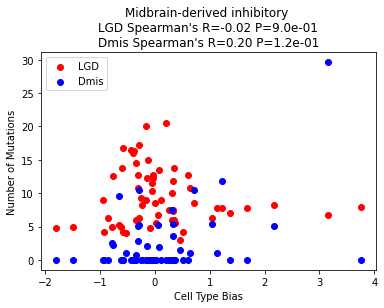

Miscellaneous


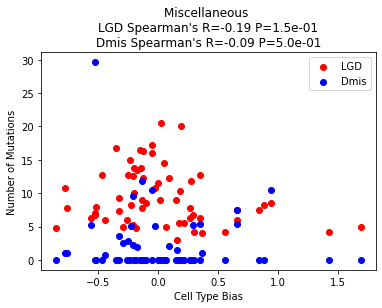

Splatter


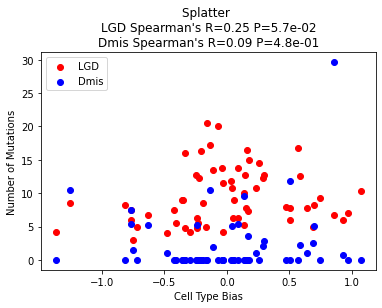

Thalamic excitatory


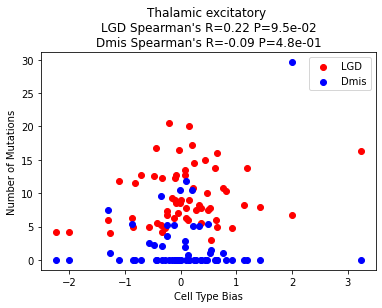

Upper rhombic lip


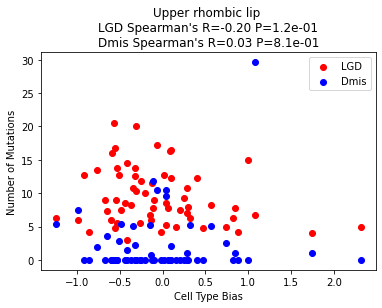

Upper-layer intratelencephalic


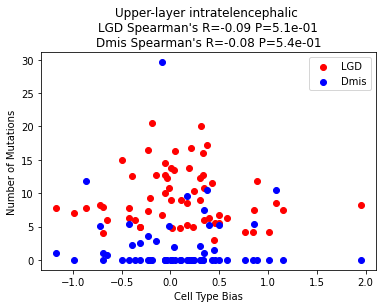

In [153]:
for CT in Neurons:
    print(CT)
    plt.scatter(Bias_CT[CT], NLGDs, label="LGD", color="red")
    plt.scatter(Bias_CT[CT], NDmis, label="Dmis", color="blue")
    plt.xlabel("Cell Type Bias")
    plt.ylabel("Number of Mutations")
    r1, p1 = spearmanr(Bias_CT[CT], NLGDs)
    r2, p2 = spearmanr(Bias_CT[CT], NDmis)
    plt.title("%s \nLGD Spearman's R=%.2f P=%.1e\nDmis Spearman's R=%.2f P=%.1e"%(CT, r1, p1, r2, p2))
    plt.legend()
    plt.show()

# ASD

In [18]:
Spark_Meta_1stage = pd.read_excel("~/Work/SPARK2020/TabS_DenovoWEST_Stage1.xlsx",
                           skiprows=1, sheet_name="AllGenes")

In [29]:
Spark_Meta_1stage.columns.values

array(['GeneID', 'EntrezID', 'HGNC', 'CytoBand', 'ExACpLI', 'LoFOvsE',
       'LOEUF', 'LOEUFbin', 'SynOvsE', 'sHet', 'Arisk', 'forecASD',
       'SFARICategory', 'SFARIScore', 'DDDCategory', 'DDDAllelic',
       'DDDMutCons', 'DDDOrgan', 'AutismMerged_LoF',
       'AutismMerged_LoF_Rate', 'ASC_LoF', 'MSSNG_LoF', 'SSC_LoF',
       'SPARK_LoF', 'Control_LoF', 'AutismMerged_Dmis_REVEL0.5',
       'AutismMerged_Dmis_REVEL0.5_Rate', 'ASC_Dmis_REVEL0.5',
       'MSSNG_Dmis_REVEL0.5', 'SSC_Dmis_REVEL0.5', 'SPARK_Dmis_REVEL0.5',
       'Control_Dmis_REVEL0.5', 'AutismMerged_Bmis_REVEL0.5',
       'AutismMerged_Bmis_REVEL0.5_Rate', 'ASC_Bmis_REVEL0.5',
       'MSSNG_Bmis_REVEL0.5', 'SSC_Bmis_REVEL0.5', 'SPARK_Bmis_REVEL0.5',
       'Control_Bmis_REVEL0.5', 'AllObserved', 'AllExpected',
       'pAllEnrich', 'MisObserved', 'MisExpected', 'pMisEnrich',
       'MisEvents', 'MisDist', 'pMisCluster', 'pMisComb', 'pDenovoWEST'],
      dtype=object)

In [23]:
Spark_Meta_1stage.head(5)

GeneID  EntrezID   HGNC  CytoBand  ExACpLI   LoFOvsE  LOEUF  \
0  ENSG00000143442     23126   POGZ    1q21.3        1  0.045859  0.119   
1  ENSG00000169057      4204  MECP2      Xq28  0.69809  0.085755  0.407   
2  ENSG00000136531      6326  SCN2A    2q24.3        1  0.060487  0.127   
3  ENSG00000171862      5728   PTEN  10q23.31  0.97551   0.24093  0.507   
4  ENSG00000173575      1106   CHD2   15q26.1        1  0.027031   0.07   

  LOEUFbin  SynOvsE      sHet  ... AllExpected pAllEnrich MisObserved  \
0        0  0.97057  0.214955  ...    0.306547        0.0       0.396   
1        1   2.0282  0.088203  ...    0.065821        0.0       4.329   
2        0   1.0084  0.257771  ...    0.734193        0.0       6.759   
3        2   1.0183   0.12616  ...    0.134423        0.0       5.661   
4        0  0.95212  0.172054  ...    0.589826        0.0        2.16   

  MisExpected pMisEnrich MisEvents MisDist pMisCluster  pMisComb  pDenovoWEST  
0    0.162758        0.1         4   170.7     0.00692   0.00583          0.0  
1     0.04961        0.0        13   170.9     0.00197       0.0          0.0  
2    0.557981        0.0        21  1271.4        0.27       0.0          0.0  
3    0.095875        0.0        17   167.3     0.00477       0.0          0.0  
4    0.375598   0.000075        10   726.9        0.02  0.000021          0.0  

[5 rows x 50 columns]

In [30]:
_, ASD_top200_GW = Aggregate_Gene_Weights2(Spark_Meta_1stage.head(200), ExpZ2Mat.index.values)
Dict2Fil(ASD_top200_GW, "../dat3/ASD.top200.gw.csv")

23126 not in allen mouse dataset
3008 don't have pLI score on file, set to 0
23096 not in allen mouse dataset
7314 not in allen mouse dataset
2290 don't have pLI score on file, set to 0
256158 don't have pLI score on file, set to 0
293 not in allen mouse dataset
90167 not in allen mouse dataset
114783 don't have pLI score on file, set to 0
23392 not in allen mouse dataset
58491 not in allen mouse dataset
54578 not in allen mouse dataset
6339 not in allen mouse dataset
1982 don't have pLI score on file, set to 0
7466 don't have pLI score on file, set to 0
7025 don't have pLI score on file, set to 0


In [32]:
len(ASD_top200_GW)

200

In [5]:
Spark_Meta_2stage = pd.read_excel("../../ASD_Circuits//dat/genes/asd/TabS_DenovoWEST_Stage1+2.xlsx",
                           skiprows=2, sheet_name="TopDnEnrich")
Spark_Meta_2stage.shape

(159, 67)

In [6]:
Spark_Meta_2stage.columns.values

array(['GeneID', 'EntrezID', 'HGNC', 'CytoBand', 'ExACpLI', 'LoFOvsE',
       'LOEUF', 'LOEUFbin', 'SynOvsE', 'sHet', 'Arisk', 'forecASD',
       'SFARICategory', 'SFARIScore', 'DDDCategory', 'DDDAllelic',
       'DDDMutCons', 'DDDOrgan', 'AutismMerged_LoF',
       'AutismMerged_LoF_Rate', 'Simplex_LoF', 'Simplex_LoF_Rate',
       'Multiplex_LoF', 'Multiplex_LoF_Rate', 'NDD_LoF', 'NDD_LoF_Rate',
       'Control_LoF', 'AutismMerged_Dmis_REVEL0.5',
       'AutismMerged_Dmis_REVEL0.5_Rate', 'Simplex_Dmis_REVEL0.5',
       'Simplex_Dmis_REVEL0.5_Rate', 'Multiplex_Dmis_REVEL0.5',
       'Multiplex_Dmis_REVEL0.5_Rate', 'NDD_Dmis_REVEL0.5',
       'NDD_Dmis_REVEL0.5_Rate', 'Control_Dmis_REVEL0.5',
       'AutismMerged_Bmis_REVEL0.5', 'AutismMerged_Bmis_REVEL0.5_Rate',
       'Simplex_Bmis_REVEL0.5', 'Simplex_Bmis_REVEL0.5_Rate',
       'Multiplex_Bmis_REVEL0.5', 'Multiplex_Bmis_REVEL0.5_Rate',
       'NDD_Bmis_REVEL0.5', 'NDD_Bmis_REVEL0.5_Rate',
       'Control_Bmis_REVEL0.5', 'AllObserved_M

In [185]:
NLGDs = []
NDmis = []
Bias_CT = {}
for i, row in Spark_Meta_2stage.head(159).iterrows():
    gene = int(row["EntrezID"])
    NLGDs.append(row["AutismMerged_LoF"])
    NDmis.append(row["AutismMerged_Dmis_REVEL0.5"])
    for CT in Neurons:
        CT_Idx = Anno[Anno["Supercluster"]==CT].index.values
        if CT not in Bias_CT:
            Bias_CT[CT] = []
        Bias_CT[CT].append(CT_Z2_MAT_HC.loc[gene, CT_Idx].mean())
NLGDs = np.array(NLGDs)
NDmis = np.array(NDmis)

In [118]:
CT = "MGE interneuron"
CT = "Medium spiny neuron"
_CT_Bias = np.array(Bias_CT[CT])
_CT_Bias > 0
NLGD_Pos = NLGDs[_CT_Bias > 0]
NLGD_Neg = NLGDs[_CT_Bias <= 0]
print(len(NLGD_Pos), len(NLGD_Neg))
Total_G = len(NLGD_Pos) + len(NLGD_Neg)
N_Mut_Pos = int(NLGD_Pos.sum())
Total_Mut = int(N_Mut_Pos + int(NLGD_Neg.sum()))
print(N_Mut_Pos, Total_Mut, N_Mut_Pos/Total_Mut / (len(NLGD_Pos)/Total_G))
print(scipy.stats.binom_test(N_Mut_Pos, Total_Mut, p=len(NLGD_Pos)/len(NLGDs)))
#print("P_binom=")

85 74
361 603 1.1198712320749196
0.0016535281518188678


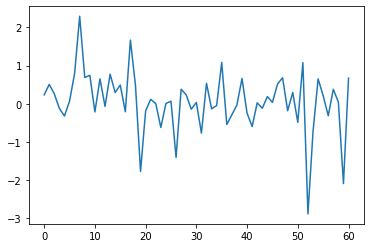

In [128]:
## Rank vs Bias
CT = "Medium spiny neuron"
CT_Idx = Anno[Anno["Supercluster"]==CT].index.values
Gene_Idx = Spark_Meta_2stage.head(61)["EntrezID"].values
dat = CT_Z2_MAT_HC.loc[Gene_Idx, CT_Idx].mean(axis=1)
plt.plot(np.arange(len(Gene_Idx)), dat,)

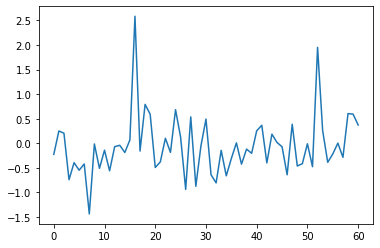

In [129]:
CT = "MGE interneuron"
CT_Idx = Anno[Anno["Supercluster"]==CT].index.values
Gene_Idx = Spark_Meta_2stage.head(61)["EntrezID"].values
dat = CT_Z2_MAT_HC.loc[Gene_Idx, CT_Idx].mean(axis=1)
plt.plot(np.arange(len(Gene_Idx)), dat,)

In [186]:
Z2Mat = pd.read_csv("../../ASD_Circuits/dat/allen-mouse-exp//AllenMouseBrain_Z2bias.csv", index_col=0)
allen_mouse_genes = Z2Mat.index.values
BGMR = pd.read_csv("~/Work/Resources/MutationRate_20170710_rate.txt", delimiter="\t")
BGMR["Entrez"] = [int(GeneSymbol2Entrez.get(x, -1)) for x in BGMR["GeneName"].values]
BGMR = BGMR[BGMR["Entrez"].isin(allen_mouse_genes)]
BGMR.index = BGMR["Entrez"].values

/tmp/ipykernel_1954016/3868777045.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  BGMR = pd.read_csv("~/Work/Resources/MutationRate_20170710_rate.txt", delimiter="\t")


In [187]:
NLGDs = []
NDmis = []
Bias_CT = {}
for i, row in Spark_Meta_2stage.head(60).iterrows():
    gene = int(row["EntrezID"])
    if gene in BGMR.index.values:
        rate1 = BGMR.loc[gene, "p_LGD"]*1e6
        rate2 = BGMR.loc[gene, "prevel_0.5"]*1e6
    else:
        rate1 = BGMR["p_LGD"].mean()*1e6
        rate2 = BGMR["prevel_0.5"].mean()*1e6
    NLGDs.append(row["AutismMerged_LoF"]/rate1)
    NDmis.append(row["AutismMerged_Dmis_REVEL0.5"]/rate2)
    for CT in Neurons:
        CT_Idx = Anno[Anno["Supercluster"]==CT].index.values
        if CT not in Bias_CT:
            Bias_CT[CT] = []
        Bias_CT[CT].append(CT_Z2_MAT_HC.loc[gene, CT_Idx].mean())
NLGDs = np.array(NLGDs)
NDmis = np.array(NDmis)

In [191]:
NLGDs = []
NDmis = []
Bias_CT = {}
for i, row in Spark_Meta_2stage.head(159).iterrows():
    gene = int(row["EntrezID"])

    NLGDs.append(row["AutismMerged_LoF"])
    NDmis.append(row["AutismMerged_Dmis_REVEL0.5"])
    for CT in Neurons:
        CT_Idx = Anno[Anno["Supercluster"]==CT].index.values
        if CT not in Bias_CT:
            Bias_CT[CT] = []
        Bias_CT[CT].append(CT_Z2_MAT_HC.loc[gene, CT_Idx].mean())
NLGDs = np.array(NLGDs)
NDmis = np.array(NDmis)

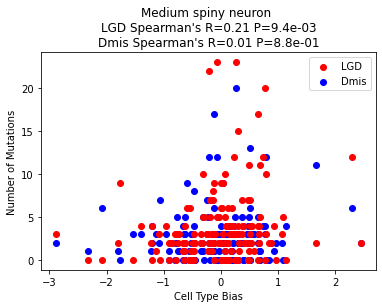

In [192]:
CT = "Medium spiny neuron"
plt.scatter(Bias_CT[CT], NLGDs, label="LGD", color="red", zorder=2)
plt.scatter(Bias_CT[CT], NDmis, label="Dmis", color="blue", zorder=1)
plt.xlabel("Cell Type Bias")
plt.ylabel("Number of Mutations")
r1, p1 = spearmanr(Bias_CT[CT], NLGDs)
r2, p2 = spearmanr(Bias_CT[CT], NDmis)
plt.title("%s \nLGD Spearman's R=%.2f P=%.1e\nDmis Spearman's R=%.2f P=%.1e"%(CT, r1, p1, r2, p2))
plt.legend()
plt.show()

Amygdala excitatory


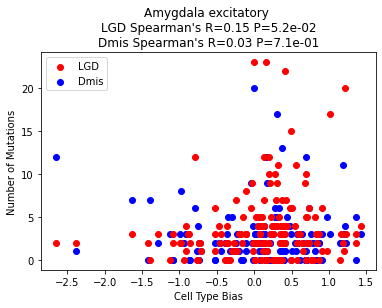

CGE interneuron


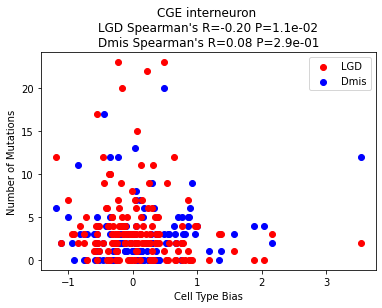

Cerebellar inhibitory


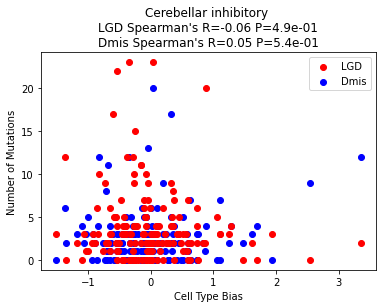

Deep-layer corticothalamic and 6b


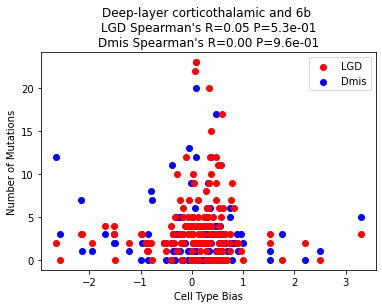

Deep-layer intratelencephalic


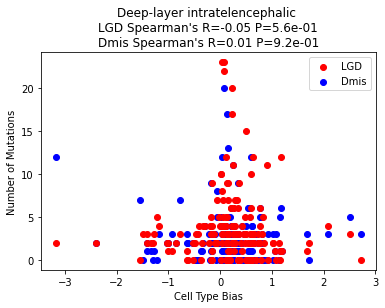

Deep-layer near-projecting


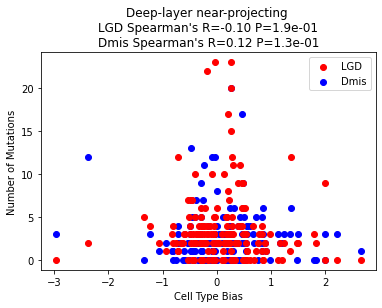

Eccentric medium spiny neuron


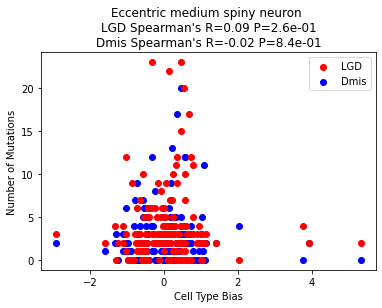

Hippocampal CA1-3


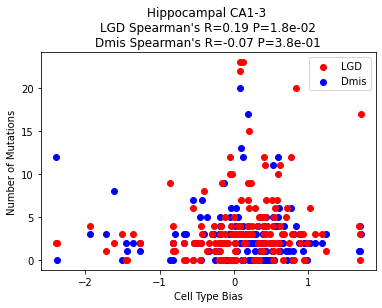

Hippocampal CA4


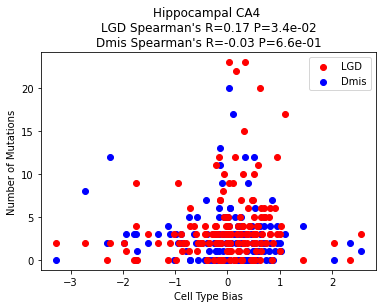

Hippocampal dentate gyrus


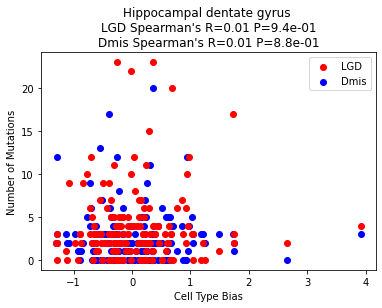

LAMP5-LHX6 and Chandelier


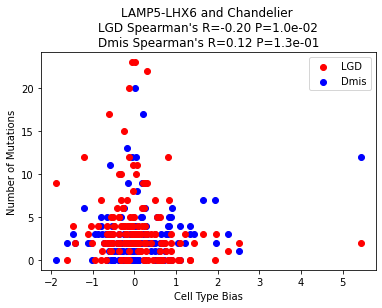

Lower rhombic lip


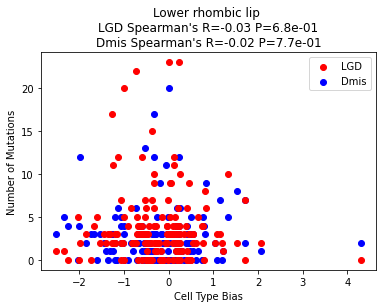

MGE interneuron


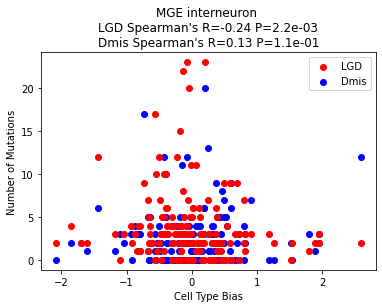

Mammillary body


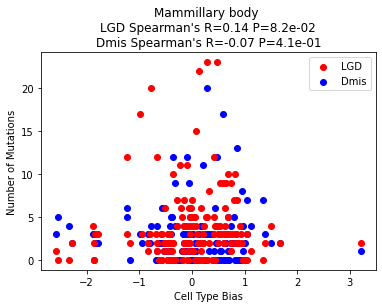

Medium spiny neuron


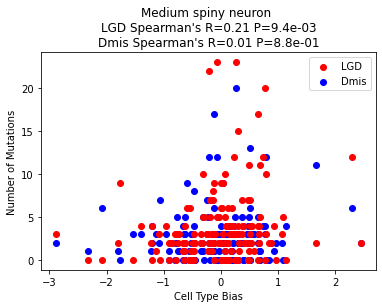

Midbrain-derived inhibitory


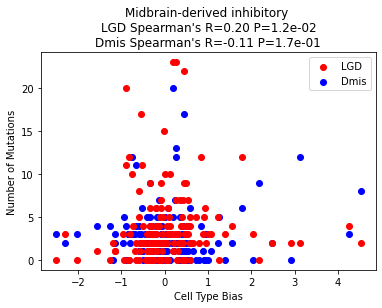

Miscellaneous


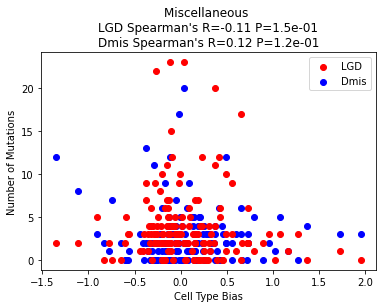

Splatter


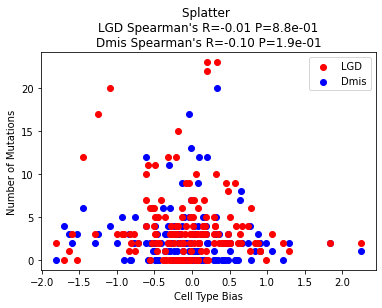

Thalamic excitatory


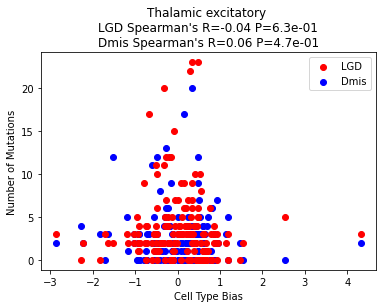

Upper rhombic lip


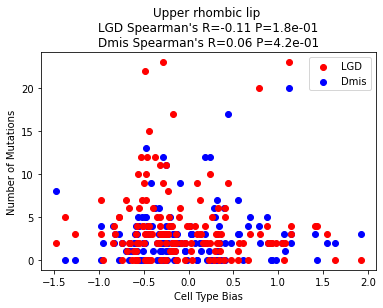

Upper-layer intratelencephalic


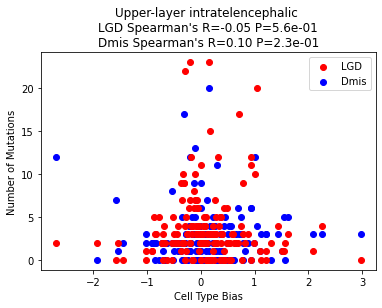

In [117]:
for CT in Neurons:
    print(CT)
    plt.scatter(Bias_CT[CT], NLGDs, label="LGD", color="red", zorder=2)
    plt.scatter(Bias_CT[CT], NDmis, label="Dmis", color="blue", zorder=1)
    plt.xlabel("Cell Type Bias")
    plt.ylabel("Number of Mutations")
    r1, p1 = spearmanr(Bias_CT[CT], NLGDs)
    r2, p2 = spearmanr(Bias_CT[CT], NDmis)
    plt.title("%s \nLGD Spearman's R=%.2f P=%.1e\nDmis Spearman's R=%.2f P=%.1e"%(CT, r1, p1, r2, p2))
    plt.legend()
    plt.show()

### High IQ vs Low IQ

In [101]:
Spark_Meta_1stage = pd.read_excel("~/Work/SPARK2020/TabS_DenovoWEST_Stage1.xlsx",
                           skiprows=1, sheet_name="AllGenes")
Spark_Denovo = pd.read_excel("../../ASD_Circuits/notebooks_v2/dat_in/41588_2022_1148_MOESM4_ESM.xlsx",
                           skiprows=2, sheet_name="Table S7")
Spark_Denovo = Spark_Denovo[Spark_Denovo[
    "pDenovoWEST_Meta"]!="."]
Spark_Denovo_ExomeWide = Spark_Denovo[Spark_Denovo[
    "pDenovoWEST_Meta"]<=2.5e-6]
Spark_Denovo_ExomeWide.shape

(63, 56)

In [104]:
top_Genes = Spark_Denovo.head(100)["HGNC"].values

In [105]:
top_Genes

array(['DNMT3A', 'POGZ', 'SCN2A', 'BRSK2', 'MECP2', 'GIGYF1', 'SLC6A1',
       'GRIN2B', 'PTEN', 'CHD2', 'KDM5B', 'FOXP1', 'KMT5B', 'ARID1B',
       'ADNP', 'SYNGAP1', 'CHD8', 'SHANK3', 'DYRK1A', 'CUL3', 'NF1',
       'ASH1L', 'DEAF1', 'KDM6B', 'DDX3X', 'ANKRD11', 'ARHGEF9', 'MYT1L',
       'TAOK1', 'RORB', 'ASXL3', 'CLCN4', 'TCF20', 'SMARCC2', 'MED13L',
       'KCNQ3', 'CTCF', 'TBL1XR1', 'MARK2', 'TSC2', 'STXBP1', 'TBR1',
       'TLK2', 'ANK2', 'DYNC1H1', 'KMT2A', 'NAA15', 'SRCAP', 'PPP2R5D',
       'SHANK2', 'RFX3', 'AUTS2', 'TCF4', 'SETD5', 'KMT2C', 'WAC',
       'CNOT3', 'WDFY3', 'EBF3', 'RAI1', 'PHF21A', 'PHIP', 'IQSEC2',
       'CTNNB1', 'EHMT1', 'PBX1', 'TNPO3', 'PRKAR1B', 'PAPOLG', 'SKI',
       'BCL11A', 'GABBR2', 'EP300', 'SATB2', 'MEF2C', 'SYNCRIP', 'KCNB1',
       'MED13', 'LMTK3', 'CELF4', 'SRPRA', 'TAF4', 'NFE2L3', 'CACNA1D',
       'DSCAM', 'TRIP12', 'SCN1A', 'CASK', 'IRF2BPL', 'NR3C2', 'MBD5',
       'DMWD', 'NUDCD2', 'RALGAPB', 'CSDE1', 'FUBP3', 'PSMD12', 'UBB',
      

In [78]:
#Mut_n_IQ = pd.read_csv("../../ASD_Circuits/dat/Other/IQ_Mutation.Mar17.2023.csv")
Mut_n_IQ = pd.read_csv("../dat/ASD_IQ_Mut.csv")
Mut_n_IQ.columns.values

array(['IID', 'Sex', 'Pheno', 'VarID', 'GeneID', 'HGNC', 'GeneEff',
       'REVEL', 'ExACpLI', 'Entrez', 'IQ'], dtype=object)

In [84]:
Mut_n_IQ = Mut_n_IQ[Mut_n_IQ["Entrez"].isin(CT_Z2_MAT_HC.index.values)]

In [85]:
Mut_n_IQ.shape

(1860, 11)

In [106]:
top_Genes = Spark_Denovo.head(100)["HGNC"].values
Mut_n_IQ_conf = Mut_n_IQ[Mut_n_IQ["HGNC"].isin(top_Genes)]
Mut_n_IQ_conf.shape

(285, 11)

In [107]:
set(Mut_n_IQ_conf["GeneEff"])

{'frameshift', 'missense', 'splice_acceptor', 'splice_donor', 'stop_gained'}

In [108]:
HighIQMuts = Mut_n_IQ_conf[Mut_n_IQ_conf["IQ"]>70]
LowIQMuts = Mut_n_IQ_conf[Mut_n_IQ_conf["IQ"]<=70]

In [109]:
HIQ_NLGD = []
HIQ_NDmis = []
LIQ_NLGD = []
LIQ_NDmis = []
HIQ_Genes = list(set(HighIQMuts["Entrez"].values))
LIQ_Genes = list(set(LowIQMuts["Entrez"].values))
print(len(HIQ_Genes), len(LIQ_Genes))

64 71


In [110]:
HIQ_Bias_CT = {}
for gene in HIQ_Genes:
    tmp_df = HighIQMuts[HighIQMuts["Entrez"]==gene]
    HIQ_NLGD.append(tmp_df[tmp_df["GeneEff"]!="missense"].shape[0])
    HIQ_NDmis.append(tmp_df[tmp_df["GeneEff"]=="missense"].shape[0])

    for CT in Neurons:
        CT_Idx = Anno[Anno["Supercluster"]==CT].index.values
        if CT not in HIQ_Bias_CT:
            HIQ_Bias_CT[CT] = []
        HIQ_Bias_CT[CT].append(CT_Z2_MAT_HC.loc[gene, CT_Idx].mean())

In [111]:
LIQ_Bias_CT = {}
for gene in LIQ_Genes:
    tmp_df = LowIQMuts[LowIQMuts["Entrez"]==gene]
    LIQ_NLGD.append(tmp_df[tmp_df["GeneEff"]!="missense"].shape[0])
    LIQ_NDmis.append(tmp_df[tmp_df["GeneEff"]=="missense"].shape[0])

    for CT in Neurons:
        CT_Idx = Anno[Anno["Supercluster"]==CT].index.values
        if CT not in LIQ_Bias_CT:
            LIQ_Bias_CT[CT] = []
        LIQ_Bias_CT[CT].append(CT_Z2_MAT_HC.loc[gene, CT_Idx].mean())

In [112]:

LIQ_NLGD = np.array(LIQ_NLGD)
HIQ_NLGD = np.array(HIQ_NLGD)
LIQ_NDmis = np.array(LIQ_NDmis)
HIQ_NDmis = np.array(HIQ_NDmis)

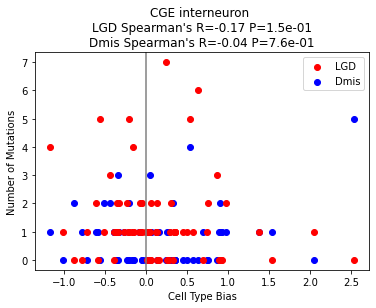

In [113]:
CT = "Medium spiny neuron"
CT = "CGE interneuron"
plt.scatter(LIQ_Bias_CT[CT], LIQ_NLGD, label="LGD", color="red", zorder=2)
plt.scatter(LIQ_Bias_CT[CT], LIQ_NDmis, label="Dmis", color="blue", zorder=1)
plt.xlabel("Cell Type Bias")
plt.ylabel("Number of Mutations")
r1, p1 = spearmanr(LIQ_Bias_CT[CT], LIQ_NLGD)
r2, p2 = spearmanr(LIQ_Bias_CT[CT], LIQ_NDmis)
plt.axvline(x = 0, color = 'grey')
plt.title("%s \nLGD Spearman's R=%.2f P=%.1e\nDmis Spearman's R=%.2f P=%.1e"%(CT, r1, p1, r2, p2))
plt.legend()
plt.show()

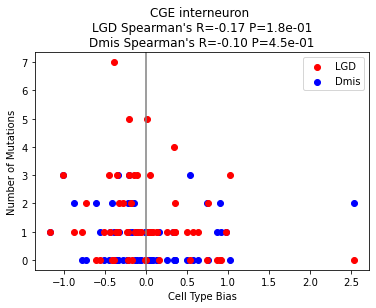

In [114]:
CT = "Medium spiny neuron"
CT = "CGE interneuron"
plt.scatter(HIQ_Bias_CT[CT], HIQ_NLGD, label="LGD", color="red", zorder=2)
plt.scatter(HIQ_Bias_CT[CT], HIQ_NDmis, label="Dmis", color="blue", zorder=1)
plt.xlabel("Cell Type Bias")
plt.ylabel("Number of Mutations")
r1, p1 = spearmanr(HIQ_Bias_CT[CT], HIQ_NLGD)
r2, p2 = spearmanr(HIQ_Bias_CT[CT], HIQ_NDmis)
plt.axvline(x = 0, color = 'grey')
plt.title("%s \nLGD Spearman's R=%.2f P=%.1e\nDmis Spearman's R=%.2f P=%.1e"%(CT, r1, p1, r2, p2))
plt.legend()
plt.show()

In [115]:
_CT_Bias = np.array(LIQ_Bias_CT[CT])
#_CT_Bias > 0
NLGD_Pos = LIQ_NLGD[_CT_Bias > 0]
NLGD_Neg = LIQ_NLGD[_CT_Bias <= 0]
print(len(NLGD_Pos), len(NLGD_Neg))
Total_G = len(NLGD_Pos) + len(NLGD_Neg)
N_Mut_Pos = NLGD_Pos.sum()
Total_Mut = NLGD_Pos.sum() + NLGD_Neg.sum()
Mut_Pos_Rate = N_Mut_Pos/Total_Mut
gene_Pos_Rate = (len(NLGD_Pos)/Total_G)
print(N_Mut_Pos, Total_Mut, Mut_Pos_Rate, gene_Pos_Rate)
print(scipy.stats.binom_test(N_Mut_Pos, Total_Mut, p=len(NLGD_Pos)/Total_G))
#print("P_binom=")

41 30
48 96 0.5 0.5774647887323944
0.14766754266192145


In [116]:
_CT_Bias = np.array(LIQ_Bias_CT[CT])
#_CT_Bias > 0
NDmis_Pos = LIQ_NDmis[_CT_Bias > 0]
NDmis_Neg = LIQ_NDmis[_CT_Bias <= 0]
print(len(NDmis_Pos), len(NDmis_Neg))
Total_G = len(NDmis_Pos) + len(NDmis_Neg)
N_Mut_Pos = NDmis_Pos.sum()
Total_Mut = NDmis_Pos.sum() + NDmis_Neg.sum()
Mut_Pos_Rate = N_Mut_Pos/Total_Mut
gene_Pos_Rate = (len(NDmis_Pos)/Total_G)
print(N_Mut_Pos, Total_Mut, Mut_Pos_Rate, gene_Pos_Rate)
print(scipy.stats.binom_test(N_Mut_Pos, Total_Mut, p=len(NDmis_Pos)/Total_G))
#print("P_binom=")

41 30
33 54 0.6111111111111112 0.5774647887323944
0.6805348421183826


In [117]:
_CT_Bias = np.array(HIQ_Bias_CT[CT])
_CT_Bias > 0
NLGD_Pos = HIQ_NLGD[_CT_Bias > 0]
NLGD_Neg = HIQ_NLGD[_CT_Bias <= 0]
print(len(NLGD_Pos), len(NLGD_Neg))
Total_G = len(HIQ_NLGD)
N_Mut_Pos = NLGD_Pos.sum()
Total_Mut = NLGD_Pos.sum() + NLGD_Neg.sum()
Mut_Pos_Rate = N_Mut_Pos/Total_Mut
gene_Pos_Rate = (len(NLGD_Pos)/Total_G)
print(N_Mut_Pos, Total_Mut, Mut_Pos_Rate, gene_Pos_Rate)
print(scipy.stats.binom_test(N_Mut_Pos, Total_Mut, p=len(NLGD_Pos)/Total_G))
#print("P_binom=")

29 35
35 88 0.3977272727272727 0.453125
0.33551864509169826


In [118]:
68-22

46

In [119]:
_CT_Bias = np.array(HIQ_Bias_CT[CT])
_CT_Bias > 0
NDmis_Pos = HIQ_NDmis[_CT_Bias > 0]
NDmis_Neg = HIQ_NDmis[_CT_Bias <= 0]
print(len(NDmis_Pos), len(NDmis_Neg))
Total_G = len(HIQ_NDmis)
N_Mut_Pos = NDmis_Pos.sum()
Total_Mut = NDmis_Pos.sum() + NDmis_Neg.sum()
Mut_Pos_Rate = N_Mut_Pos/Total_Mut
gene_Pos_Rate = (len(NDmis_Pos)/Total_G)
print(N_Mut_Pos, Total_Mut, Mut_Pos_Rate, gene_Pos_Rate)
print(scipy.stats.binom_test(N_Mut_Pos, Total_Mut, p=len(NDmis_Pos)/Total_G))
#print("P_binom=")

29 35
16 47 0.3404255319148936 0.453125
0.14286486838526882


## CT Z2 vs IQ

### Human Data

In [339]:
#CT_Bias = pd.read_csv("test.ct.z2.bias.csv", index_col="STR")
#CT_Bias = pd.read_csv("../../CellType_Psy/dat/Bias/ASD.Spark61.CT.hc.bias.csv", index_col=0)
HCT_Z2_MAT_HCT = pd.read_csv("../dat/HumanCTExpressionMats/Human.CT.Exp.Entrez.log2.Z2.HCT.z1clip3.csv", index_col=0)
max_Z, min_Z = 3, -3
HCT_Z2_MAT_HCT = HCT_Z2_MAT_HCT.clip(upper=max_Z, lower=min_Z)
HCT_Z2_MAT_HCT.columns = [int(x) for x in HCT_Z2_MAT_HCT.columns.values]

In [340]:
top_Genes = Spark_Denovo.head(61)["HGNC"].values
Mut_n_IQ_conf = Mut_n_IQ[Mut_n_IQ["HGNC"].isin(top_Genes)]
Mut_n_IQ_conf.shape

(221, 11)

In [341]:
def BiasVsPheno(MutPhenoDF, BiasMat, STR, label):
    biases = []
    IQs = []
    for i, row in MutPhenoDF.iterrows():
        if label == 'label':
            gene = row["HGNC"]
        else:
            gene = int(row["Entrez"])
        if gene in BiasMat.index.values:
            bias = BiasMat.loc[gene, STR]
            if bias == bias:
                IQ = row["IQ"]
                biases.append(bias)
                IQs.append(IQ)
    return biases, IQs

In [342]:
Mut_n_IQ_conf_LGD = Mut_n_IQ_conf[Mut_n_IQ_conf["GeneEff"]!="missense"]
Mut_n_IQ_conf_Dmis = Mut_n_IQ_conf[Mut_n_IQ_conf["GeneEff"]=="missense"]

In [343]:
def Plot_Bias_vs_IQ(STR, Mut_n_IQ_conf=Mut_n_IQ_conf, HCT_Z2_MAT_HCT = HCT_Z2_MAT_HCT):
    biases, IQs = BiasVsPheno(Mut_n_IQ_conf, HCT_Z2_MAT_HCT , STR, 'XX')
    pho, p = spearmanr(biases, IQs)
    # Create the scatter plot
    plt.figure(dpi=150, figsize=(5, 4))

    # Plot data points
    plt.scatter(biases, IQs, s=50, color="#2c7bb6", edgecolor="black", alpha=0.8, zorder=10)

    # Fit and plot the trend line
    b, a = np.polyfit(biases, IQs, deg=1)
    xseq = np.linspace(min(biases), max(biases), num=100)
    plt.plot(xseq, a + b * xseq, color="#d7191c", lw=2.5, linestyle='--', zorder=5)
    _SuperCluster = Anno.loc[STR, "Supercluster"]
    # Add title with improved formatting
    plt.title(f'{_SuperCluster} - {STR} \nSpearman ρ = {pho:.2f}, p = {p:.2e}', fontsize=14, fontweight='bold')

    # Labeling axes
    plt.xlabel("Cell Type Bias", fontsize=12, fontweight='bold')
    plt.ylabel("Full Scale IQ", fontsize=12, fontweight='bold')

    # Grid lines for better readability
    plt.grid(True, linestyle='--', alpha=0.5)

    # Adjust tick parameters
    plt.xticks(fontsize=10, fontweight='bold')
    plt.yticks(fontsize=10, fontweight='bold')

    # Tight layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

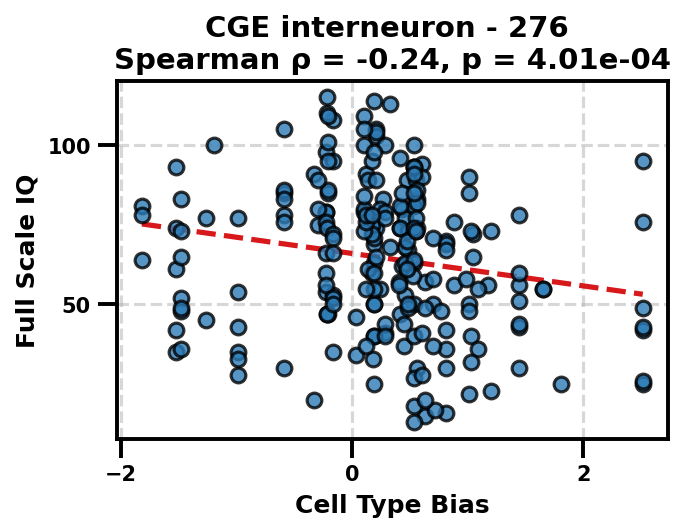

In [344]:
STR = 276
Plot_Bias_vs_IQ(STR, Mut_n_IQ_conf)

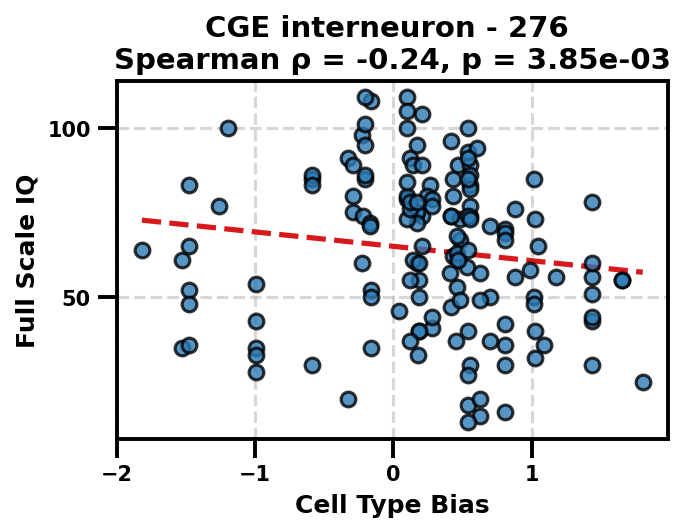

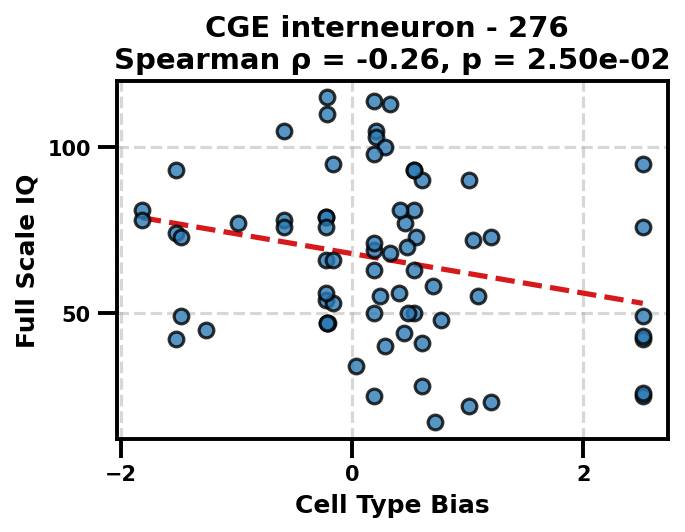

In [352]:
STR = 276
Plot_Bias_vs_IQ(STR, Mut_n_IQ_conf_LGD)
Plot_Bias_vs_IQ(STR, Mut_n_IQ_conf_Dmis)

In [345]:
Neuron_idx = Anno[Anno["Supercluster"].isin(Neurons)].index.values

In [434]:
names, supercluster, correlation, pvalues = [],[],[],[]
for STR in Neuron_idx:
    #print(STR, CT_Bias.loc[STR, "Supercluster"])
    biases, IQs = BiasVsPheno(Mut_n_IQ_conf, HCT_Z2_MAT_HCT , STR, 'xx')
    pho, p = spearmanr(biases, IQs)
    #print(pho, p)
    names.append("{}- {}".format(STR, Anno.loc[STR, "Supercluster"]))
    supercluster.append(Anno.loc[STR, "Supercluster"])
    correlation.append(pho)
    pvalues.append(p)
human_ct_res_df_mutL = pd.DataFrame(data={"CT":names, "Supercluster":supercluster, "SpearmanR":correlation, "p":pvalues})
human_ct_res_df_mutL = human_ct_res_df_mutL.sort_values("SpearmanR")
human_ct_res_df_mutL = ADJ_P(human_ct_res_df_mutL)
human_ct_res_df_mutL.to_csv("../dat/Pheno_Bias_vs_IQ/HumanCT.mutL.csv")

In [350]:
#### Gene Level
Genes = list(set(Mut_n_IQ_conf["Entrez"].values))
data = []
for g in Genes:
    tmp_df = Mut_n_IQ_conf[Mut_n_IQ_conf["Entrez"]==g]
    avg_IQ = tmp_df["IQ"].mean()
    row = [g, avg_IQ]
    data.append(row)
columns = ["Entrez", "IQ"]
Avg_Gene_IQ_DF = pd.DataFrame(data=data, columns=columns)

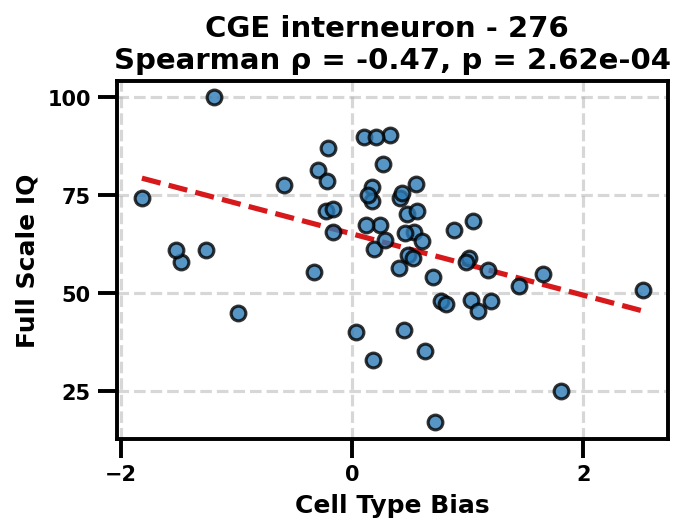

In [351]:
STR = 293
STR = 276
Plot_Bias_vs_IQ(STR, Avg_Gene_IQ_DF)

In [354]:
Genes = list(set(Mut_n_IQ_conf_LGD["Entrez"].values))
data = []
for g in Genes:
    tmp_df = Mut_n_IQ_conf_LGD[Mut_n_IQ_conf_LGD["Entrez"]==g]
    avg_IQ = tmp_df["IQ"].mean()
    row = [g, avg_IQ]
    data.append(row)
columns = ["Entrez", "IQ"]
Avg_Gene_IQ_LGD_DF = pd.DataFrame(data=data, columns=columns)

Genes = list(set(Mut_n_IQ_conf_Dmis["Entrez"].values))
data = []
for g in Genes:
    tmp_df = Mut_n_IQ_conf_Dmis[Mut_n_IQ_conf_Dmis["Entrez"]==g]
    avg_IQ = tmp_df["IQ"].mean()
    row = [g, avg_IQ]
    data.append(row)
columns = ["Entrez", "IQ"]
Avg_Gene_IQ_Dmis_DF = pd.DataFrame(data=data, columns=columns)

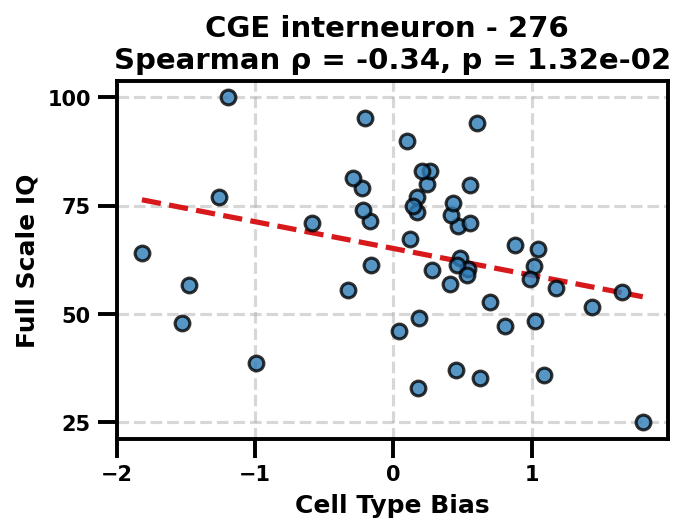

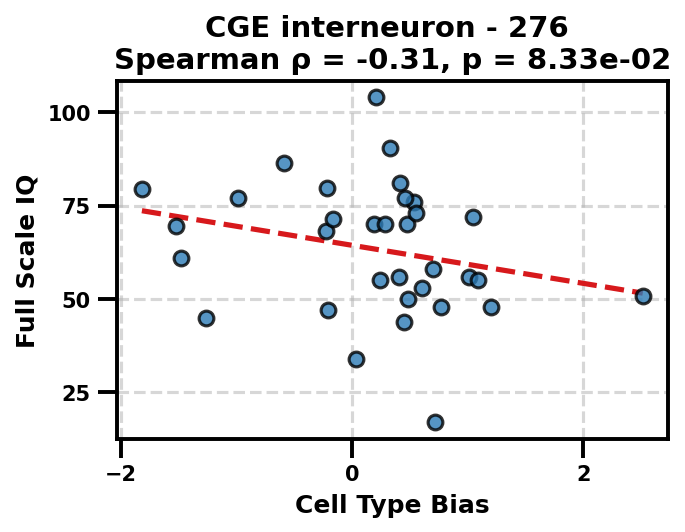

In [355]:
STR = 276
Plot_Bias_vs_IQ(STR, Avg_Gene_IQ_LGD_DF)
Plot_Bias_vs_IQ(STR, Avg_Gene_IQ_Dmis_DF)

In [433]:
names, supercluster, correlation, pvalues = [],[],[],[]
for STR in Neuron_idx:
    #print(STR, CT_Bias.loc[STR, "Supercluster"])
    biases, IQs = BiasVsPheno(Avg_Gene_IQ_DF, HCT_Z2_MAT_HCT , STR, 'xx')
    pho, p = spearmanr(biases, IQs)
    #print(pho, p)
    names.append("{}- {}".format(STR, Anno.loc[STR, "Supercluster"]))
    supercluster.append(Anno.loc[STR, "Supercluster"])
    correlation.append(pho)
    pvalues.append(p)
    #print()
human_ct_res_df_geneL = pd.DataFrame(data={"CT":names, "Supercluster":supercluster, "SpearmanR":correlation, "p":pvalues})
human_ct_res_df_geneL = human_ct_res_df_geneL.sort_values("SpearmanR")
human_ct_res_df_geneL = ADJ_P(human_ct_res_df_geneL)
human_ct_res_df_geneL.to_csv("../dat/Pheno_Bias_vs_IQ/HumanCT.GeneL.csv")

In [279]:
ct_res_df_geneL = pd.DataFrame(data={"CT":names, "Supercluster":supercluster, "SpearmanR":correlation, "p":pvalues})
ct_res_df_geneL = ct_res_df_geneL.sort_values("SpearmanR")
ct_res_df_geneL.head(2)

CT               Supercluster  SpearmanR  \
188  267- LAMP5-LHX6 and Chandelier  LAMP5-LHX6 and Chandelier  -0.490002   
197            276- CGE interneuron            CGE interneuron  -0.469529   

            p  
188  0.000126  
197  0.000262

In [281]:
ct_res_df_geneL.head(20)

CT               Supercluster  SpearmanR  \
188  267- LAMP5-LHX6 and Chandelier  LAMP5-LHX6 and Chandelier  -0.490002   
197            276- CGE interneuron            CGE interneuron  -0.469529   
187  266- LAMP5-LHX6 and Chandelier  LAMP5-LHX6 and Chandelier  -0.456711   
189  268- LAMP5-LHX6 and Chandelier  LAMP5-LHX6 and Chandelier  -0.429504   
158                   237- Splatter                   Splatter  -0.399323   
215            294- CGE interneuron            CGE interneuron  -0.395939   
186  265- LAMP5-LHX6 and Chandelier  LAMP5-LHX6 and Chandelier  -0.389411   
190  269- LAMP5-LHX6 and Chandelier  LAMP5-LHX6 and Chandelier  -0.387018   
216            295- CGE interneuron            CGE interneuron  -0.381379   
160            239- MGE interneuron            MGE interneuron  -0.380217   
180            259- MGE interneuron            MGE interneuron  -0.372355   
214            293- CGE interneuron            CGE interneuron  -0.352326   
191  270- LAMP5-LHX6 and Chandelier  LAMP5-LHX6 and Chandelier  -0.338688   
202            281- CGE interneuron            CGE interneuron  -0.335236   
181            260- MGE interneuron            MGE interneuron  -0.334040   
192  271- LAMP5-LHX6 and Chandelier  LAMP5-LHX6 and Chandelier  -0.333049   
198            277- CGE interneuron            CGE interneuron  -0.330451   
205            284- CGE interneuron            CGE interneuron  -0.327375   
194  273- LAMP5-LHX6 and Chandelier  LAMP5-LHX6 and Chandelier  -0.326315   
207            286- CGE interneuron            CGE interneuron  -0.324435   

            p  
188  0.000126  
197  0.000262  
187  0.000403  
189  0.000955  
158  0.002298  
215  0.002523  
186  0.003013  
190  0.003213  
216  0.003731  
160  0.003846  
180  0.004713  
214  0.007743  
191  0.010671  
202  0.011549  
181  0.011867  
192  0.012136  
198  0.012868  
205  0.013783  
194  0.014111  
207  0.014709

In [283]:
ct_res_df.head(10)

CT               Supercluster  SpearmanR  \
188  267- LAMP5-LHX6 and Chandelier  LAMP5-LHX6 and Chandelier  -0.277066   
187  266- LAMP5-LHX6 and Chandelier  LAMP5-LHX6 and Chandelier  -0.264943   
197            276- CGE interneuron            CGE interneuron  -0.236066   
186  265- LAMP5-LHX6 and Chandelier  LAMP5-LHX6 and Chandelier  -0.230256   
214            293- CGE interneuron            CGE interneuron  -0.218669   
216            295- CGE interneuron            CGE interneuron  -0.216873   
189  268- LAMP5-LHX6 and Chandelier  LAMP5-LHX6 and Chandelier  -0.210757   
217            296- CGE interneuron            CGE interneuron  -0.210735   
215            294- CGE interneuron            CGE interneuron  -0.208458   
190  269- LAMP5-LHX6 and Chandelier  LAMP5-LHX6 and Chandelier  -0.204759   

            p  
188  0.000029  
187  0.000067  
197  0.000401  
186  0.000560  
214  0.001068  
216  0.001177  
189  0.001628  
217  0.001630  
215  0.001835  
190  0.002219

In [294]:
def SuperClusterBias_BoxPlot_CorrIQ(DF1, DF2):
    dat_Z2 = []
    mean_Z2 = []
    for _CT in Neurons:
        tmp = DF1[DF1["Supercluster"] == _CT]
        dat_Z2.append(tmp["SpearmanR"].values)
        mean_Z2.append(np.mean(tmp["SpearmanR"].values))
    mean_Z2 = np.array(mean_Z2)

    # Sorting data by the mean values
    sort_idx = np.argsort(mean_Z2)
    show_dat_Z2 = [dat_Z2[x] for x in sort_idx]
    show_CTs = [ALL_CTs[x] for x in sort_idx]

    # Create a figure and axis
    fig, ax = plt.subplots(dpi=480, figsize=(8, 8))

    # Customize the boxplot
    boxprops = dict(linestyle='-', linewidth=1.5, color='blue', facecolor='lightblue')
    medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')
    meanprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')

    # Use Seaborn to set the context for publication-quality plots
    sns.set_context("talk", font_scale=1.2)

    # Draw the boxplot
    bp = ax.boxplot(show_dat_Z2, labels=show_CTs, vert=False, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', color='blue'),
                    medianprops=medianprops, meanprops=meanprops, showmeans=True)

    # Add grid lines
    ax.grid(True, linestyle='--', alpha=0.6)

    # Customize the colors of the boxplot elements
    colors = sns.color_palette("Set2", len(show_dat_Z2))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    # Add labels and title
    ax.set_xlabel("Correlation With IQ", fontsize=14)
    ax.set_ylabel("Supercluster", fontsize=14)

    # Adjust the tick parameters for better readability
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()

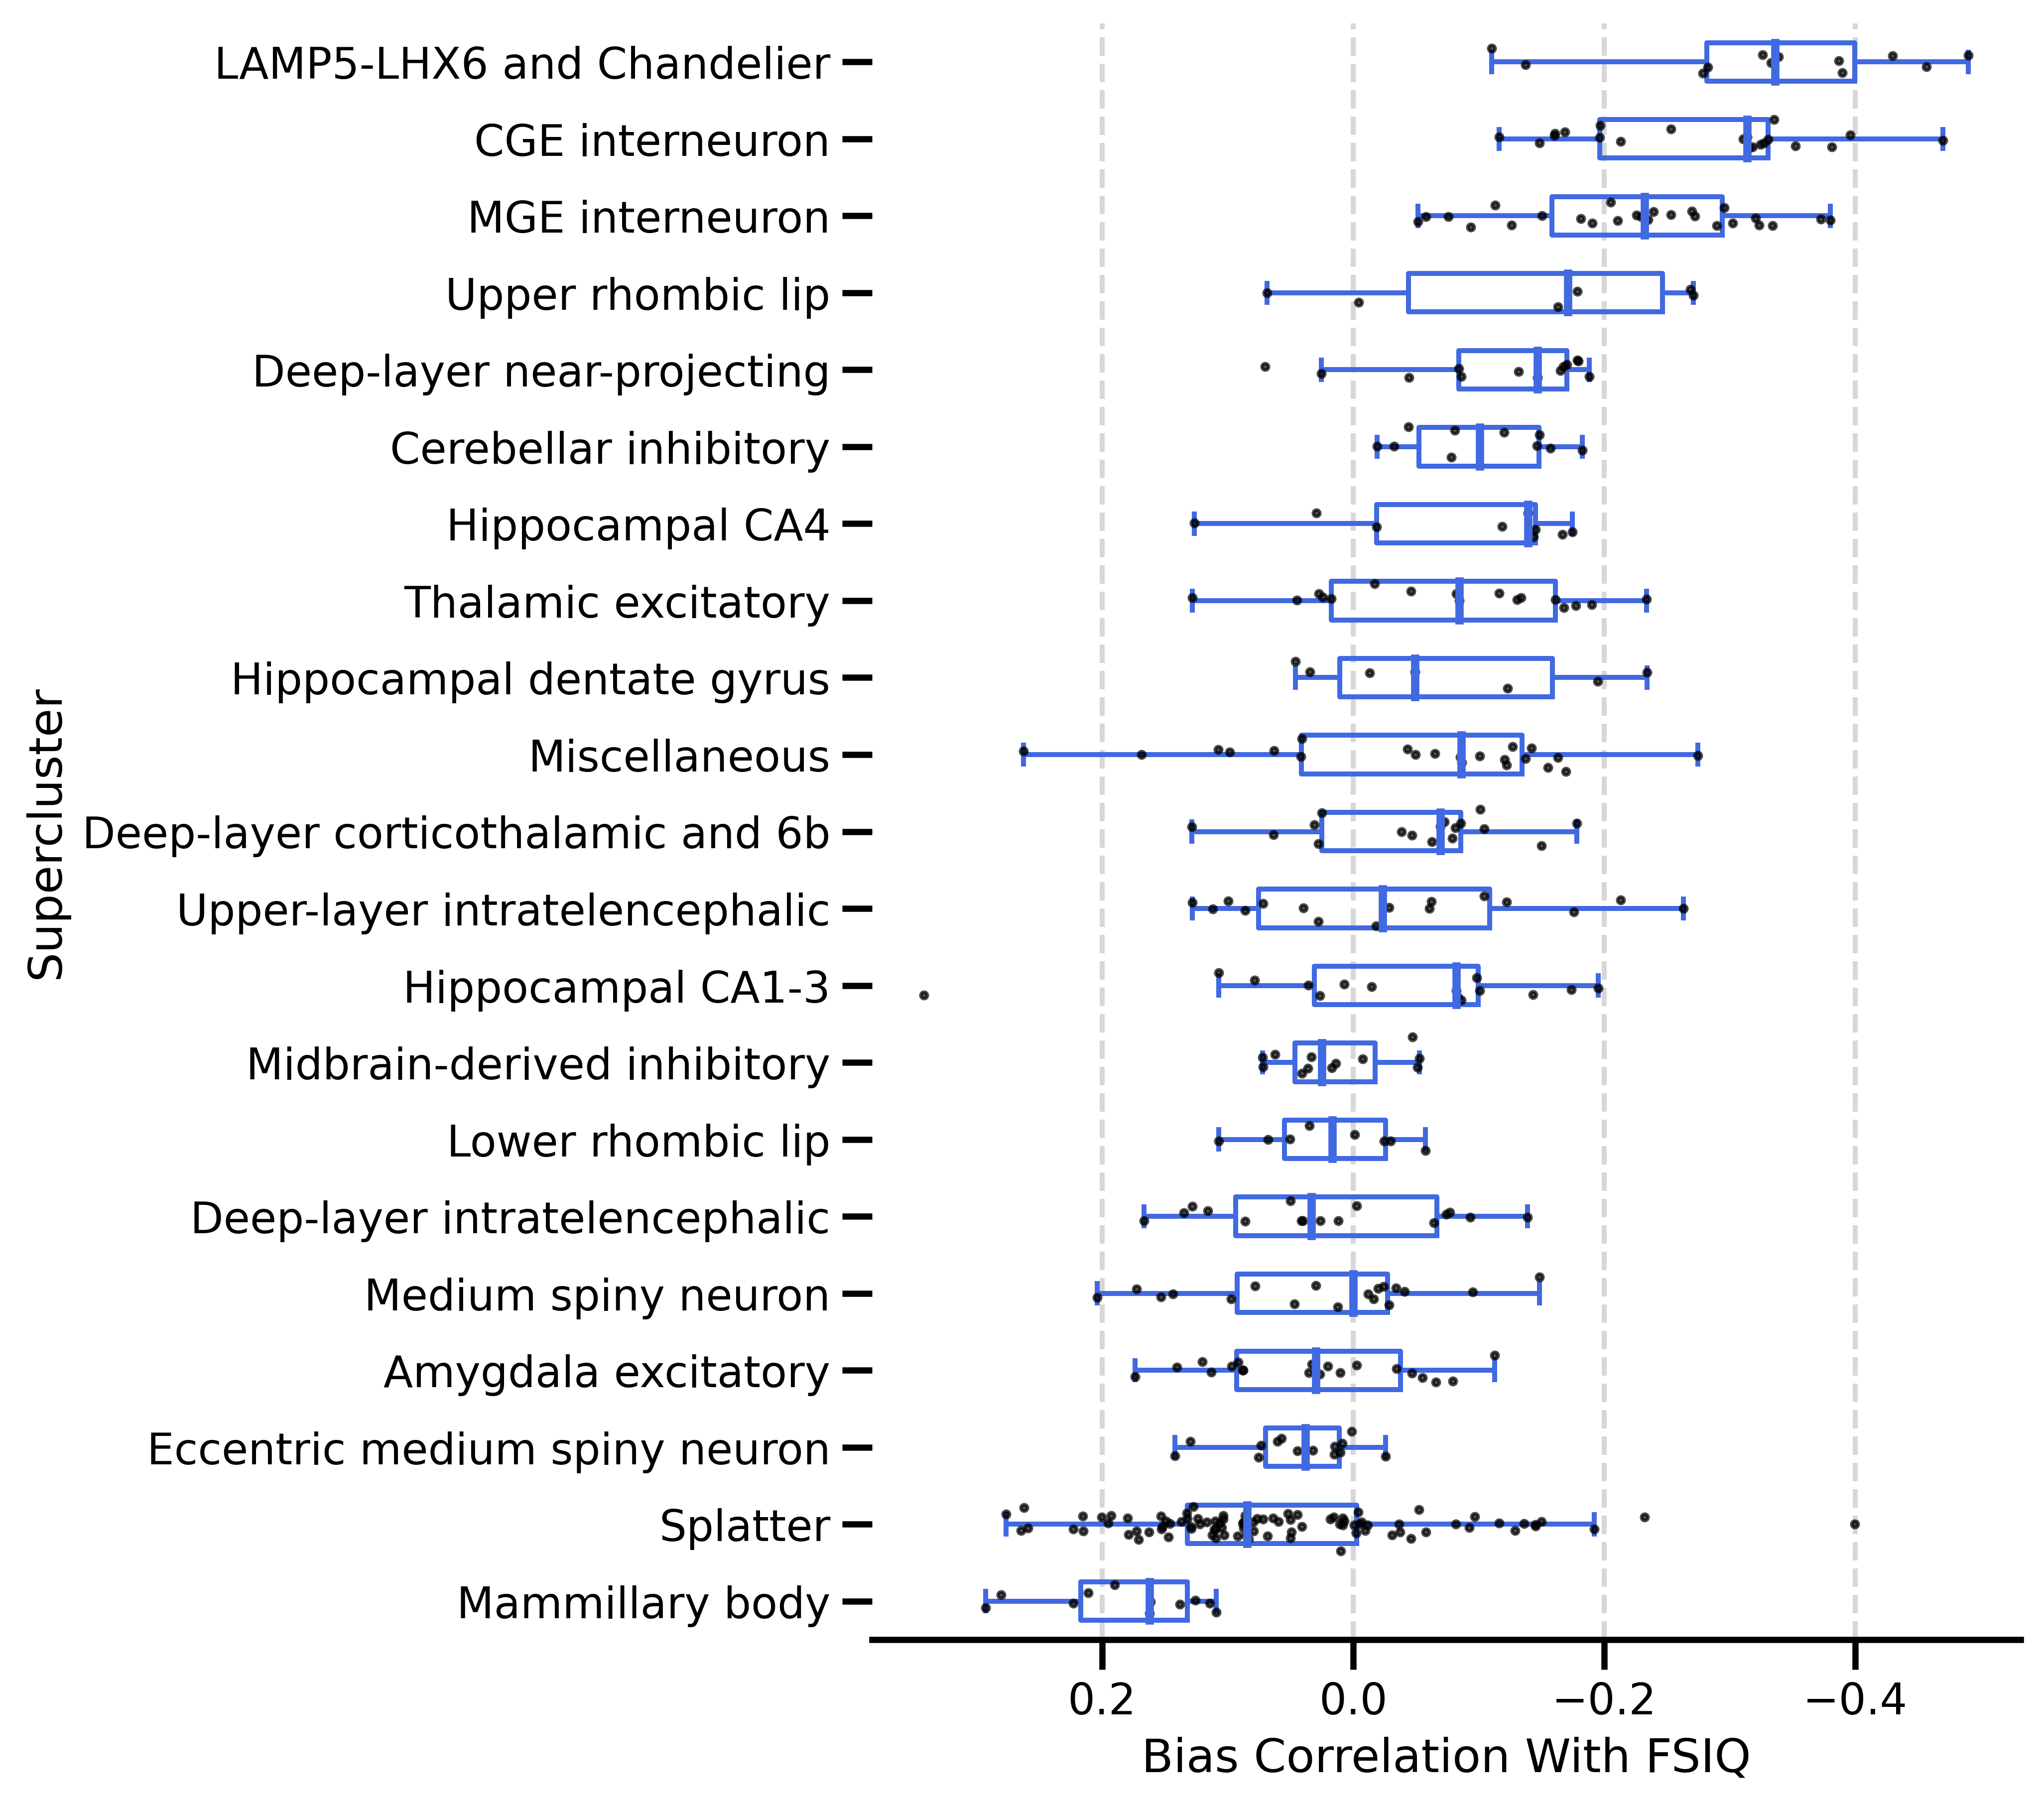

In [359]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def SuperClusterBias_BoxPlot_CorrIQ(DF1, DF2):
    dat_Z2 = []
    mean_Z2 = []
    for _CT in Neurons:
        tmp = DF1[DF1["Supercluster"] == _CT]
        dat_Z2.append(tmp["SpearmanR"].values)
        mean_Z2.append(np.mean(tmp["SpearmanR"].values))
    mean_Z2 = np.array(mean_Z2)

    # Sorting data by the mean values
    sort_idx = np.argsort(mean_Z2)[::-1]  # Reverse the sorting order
    show_dat_Z2 = [dat_Z2[x] for x in sort_idx]
    show_CTs = [ALL_CTs[x] for x in sort_idx]

    # Create a figure and axis
    fig, ax = plt.subplots(dpi=480, figsize=(9, 8))

    # Customize the boxplot to only show the edges with the same color
    boxprops = dict(linestyle='-', linewidth=1.5, color='royalblue')
    medianprops = dict(linestyle='-', linewidth=2.5, color='royalblue')
    whiskerprops = dict(color='royalblue', linewidth=1.5)
    capprops = dict(color='royalblue', linewidth=1.5)
    flierprops = dict(marker='', color='royalblue', alpha=0.5)  # Adjusted to not show outliers

    # Use Seaborn to set the context for publication-quality plots
    sns.set_context("talk", font_scale=1.2)

    # Draw the boxplot
    bp = ax.boxplot(show_dat_Z2, labels=show_CTs, vert=False, patch_artist=False,
                    boxprops=boxprops, medianprops=medianprops, 
                    whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops)

    # Overlay each data point on the boxplot
    for i in range(len(show_dat_Z2)):
        y = np.random.normal(i + 1, 0.1, size=len(show_dat_Z2[i]))  # jitter for better visibility
        ax.plot(show_dat_Z2[i], y, 'o', markersize=2, color='black', alpha=0.7)

    # Add grid lines
    ax.grid(True, axis='x', linestyle='--', alpha=0.6)

    # Add labels and title
    ax.set_xlabel("Bias Correlation With FSIQ", fontsize=14)
    ax.set_ylabel("Supercluster", fontsize=14)

    # Flip the x-axis
    ax.invert_xaxis()

    # Adjust the tick parameters for better readability
    ax.tick_params(axis='both', which='major', labelsize=13, grid_alpha=0.5)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage with your DataFrames DF1 and DF2
SuperClusterBias_BoxPlot_CorrIQ(ct_res_df_geneL, ct_res_df)


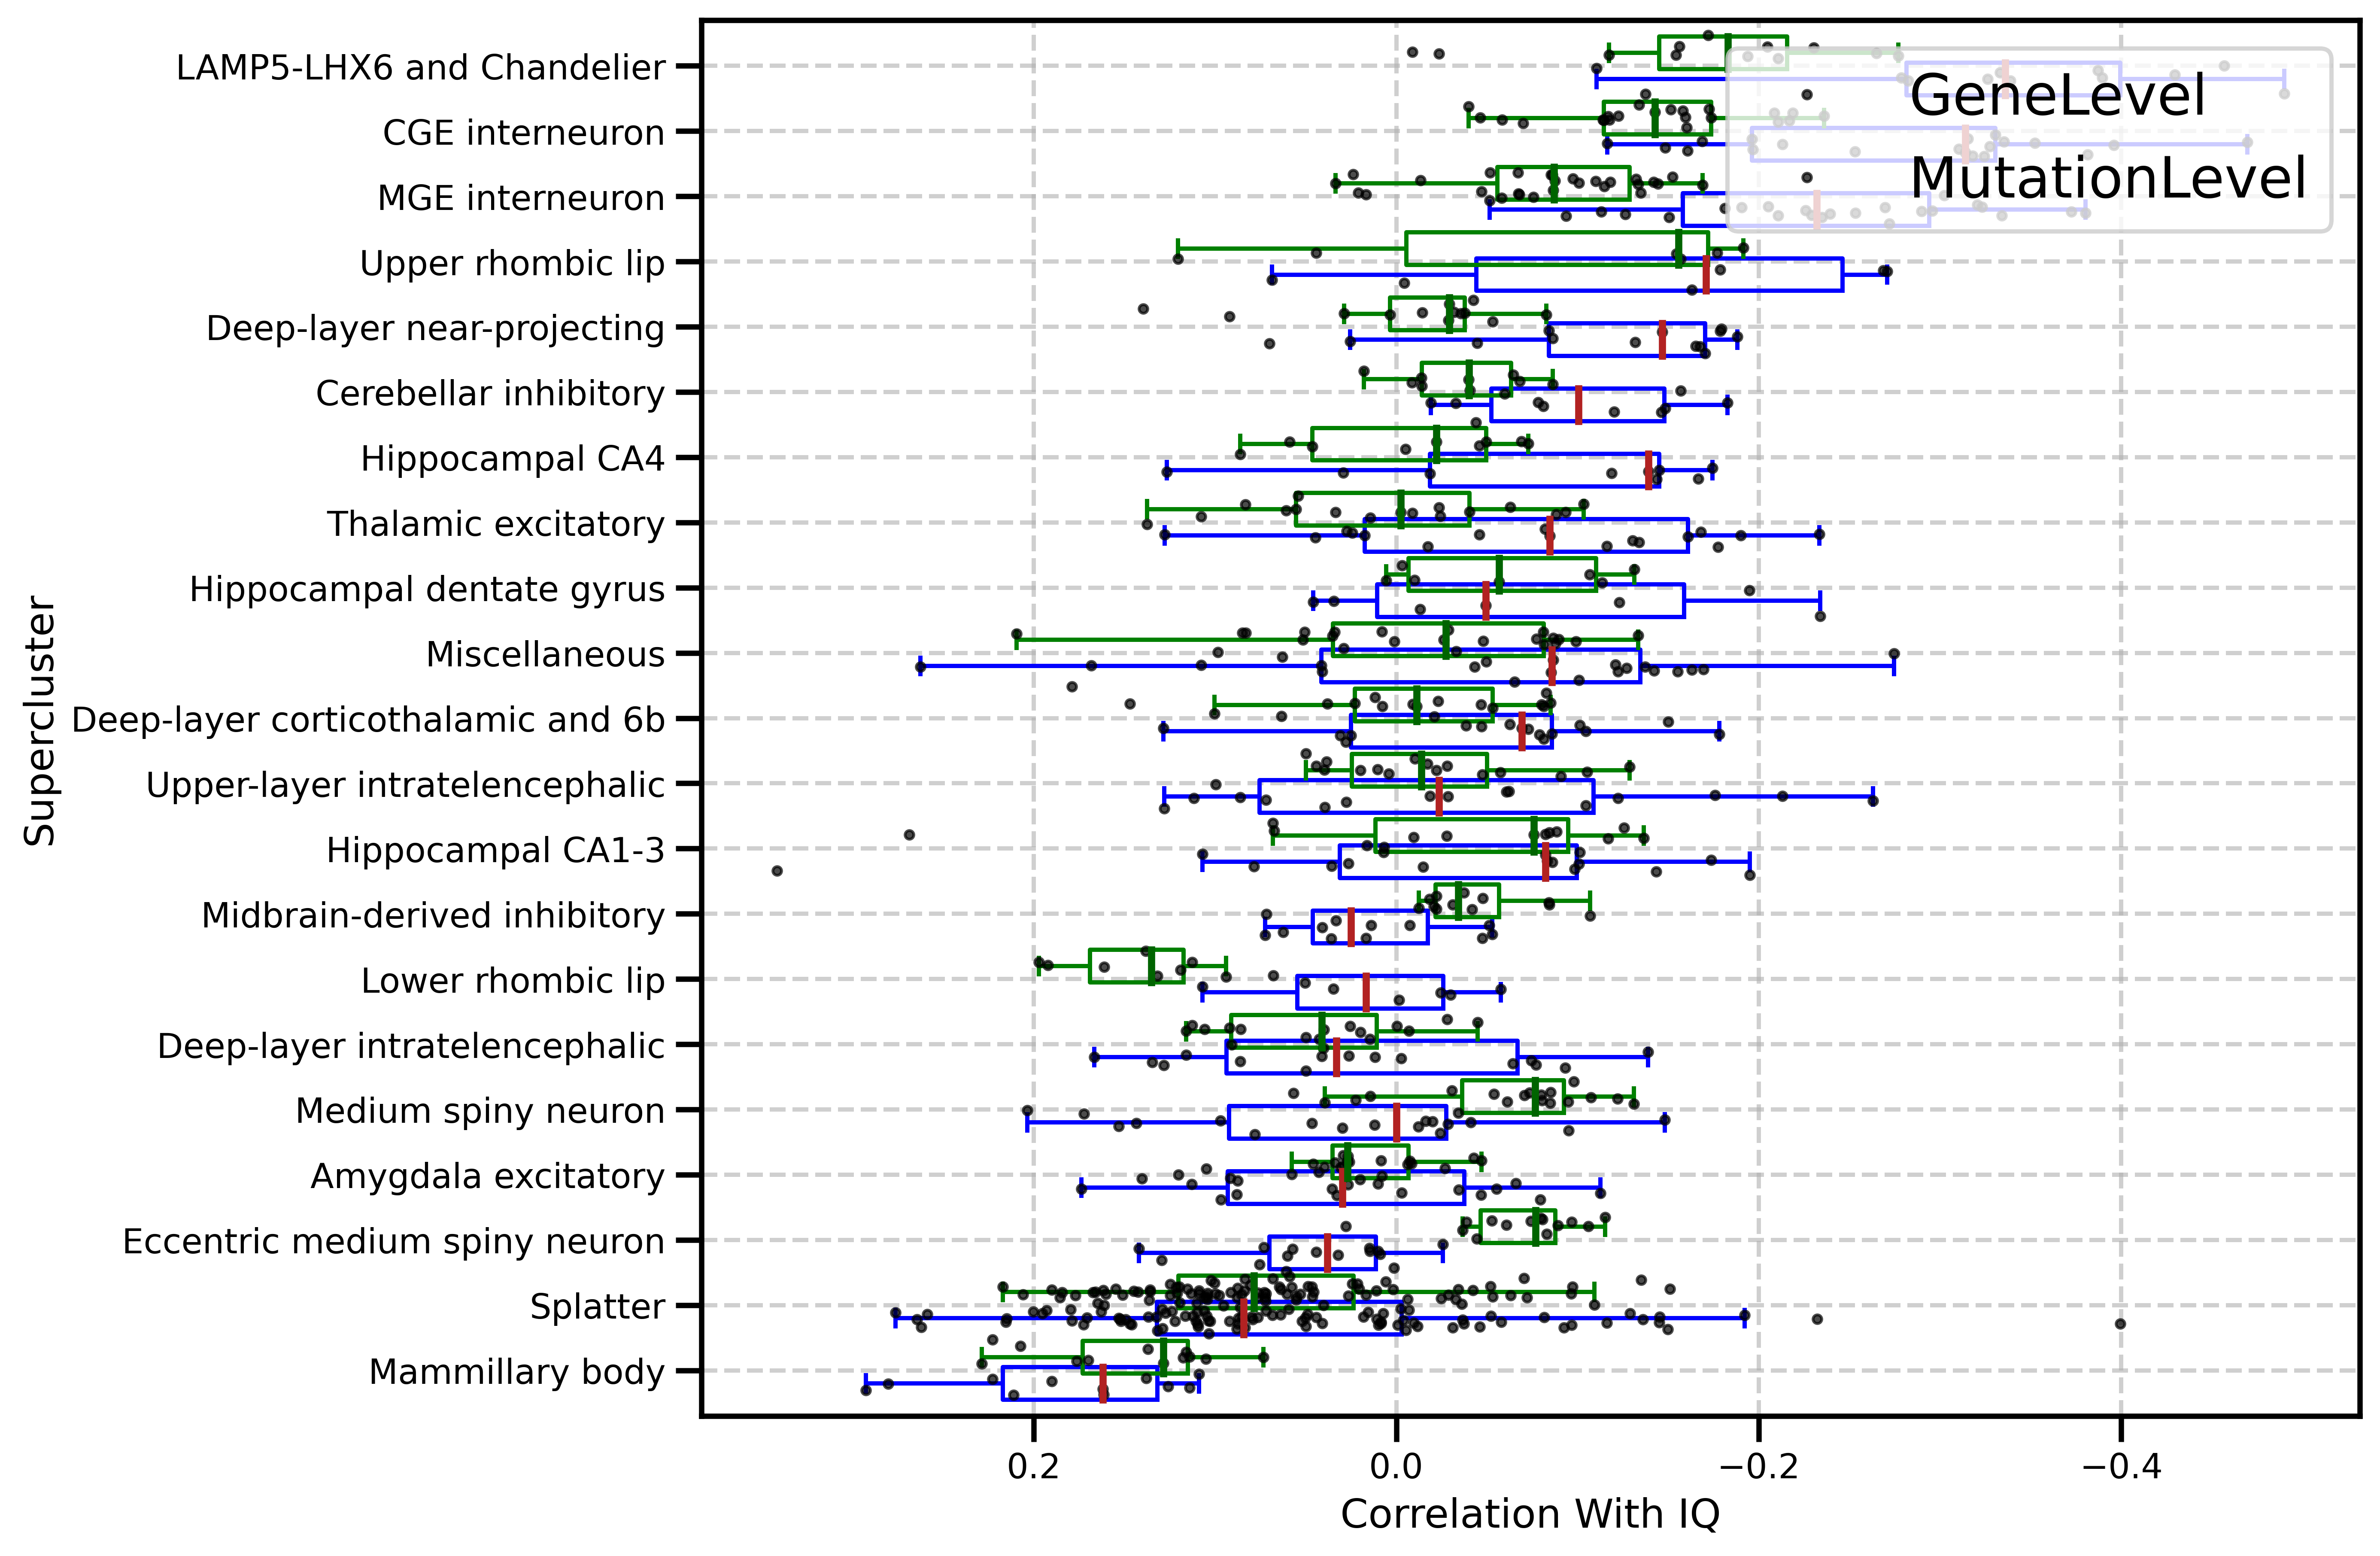

In [317]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def SuperClusterBias_BoxPlot_CorrIQ(DF1, DF2):
    # Initialize lists to hold data for both dataframes
    dat_Z2_1 = []
    dat_Z2_2 = []
    mean_Z2_1 = []
    mean_Z2_2 = []

    # Process DF1
    for _CT in Neurons:
        tmp = DF1[DF1["Supercluster"] == _CT]
        dat_Z2_1.append(tmp["SpearmanR"].values)
        mean_Z2_1.append(np.mean(tmp["SpearmanR"].values))
    mean_Z2_1 = np.array(mean_Z2_1)

    # Process DF2
    for _CT in Neurons:
        tmp = DF2[DF2["Supercluster"] == _CT]
        dat_Z2_2.append(tmp["SpearmanR"].values)
        mean_Z2_2.append(np.mean(tmp["SpearmanR"].values))
    mean_Z2_2 = np.array(mean_Z2_2)

    # Sorting data by the mean values of DF1
    sort_idx = np.argsort(mean_Z2_1)[::-1]  # Reverse the sorting order
    show_dat_Z2_1 = [dat_Z2_1[x] for x in sort_idx]
    show_dat_Z2_2 = [dat_Z2_2[x] for x in sort_idx]
    show_CTs = [ALL_CTs[x] for x in sort_idx]

    # Create a figure and axis
    fig, ax = plt.subplots(dpi=480, figsize=(12, 8))

    # Customize the boxplot to show edges with the same color
    boxprops_1 = dict(linestyle='-', linewidth=1.5, color='blue')
    medianprops_1 = dict(linestyle='-', linewidth=2.5, color='firebrick')
    whiskerprops_1 = dict(color='blue', linewidth=1.5)
    capprops_1 = dict(color='blue', linewidth=1.5)
    flierprops_1 = dict(marker='', color='blue', alpha=0.5)

    boxprops_2 = dict(linestyle='-', linewidth=1.5, color='green')
    medianprops_2 = dict(linestyle='-', linewidth=2.5, color='darkgreen')
    whiskerprops_2 = dict(color='green', linewidth=1.5)
    capprops_2 = dict(color='green', linewidth=1.5)
    flierprops_2 = dict(marker='', color='green', alpha=0.5)

    # Use Seaborn to set the context for publication-quality plots
    sns.set_context("talk", font_scale=1.2)

    # Draw the boxplot for DF1
    bp1 = ax.boxplot(show_dat_Z2_1, labels=[f'{ct}' for ct in show_CTs], vert=False, patch_artist=False,
                     boxprops=boxprops_1, medianprops=medianprops_1, 
                     whiskerprops=whiskerprops_1, capprops=capprops_1, flierprops=flierprops_1,
                     positions=np.array(range(1, len(show_CTs) + 1)))  # Positions for DF1

    # Draw the boxplot for DF2 (shifted by 0.4 for visibility)
    bp2 = ax.boxplot(show_dat_Z2_2, labels=[f'{ct}' for ct in show_CTs], vert=False, patch_artist=False,
                     boxprops=boxprops_2, medianprops=medianprops_2, 
                     whiskerprops=whiskerprops_2, capprops=capprops_2, flierprops=flierprops_2,
                     positions=np.array(range(1, len(show_CTs) + 1)) + 0.4)  # Shift positions

    # Overlay each data point on the boxplot
    for i in range(len(show_dat_Z2_1)):
        y1 = np.random.normal(i + 1, 0.1, size=len(show_dat_Z2_1[i]))  # jitter for better visibility
        ax.plot(show_dat_Z2_1[i], y1, 'o', markersize=3, color='black', alpha=0.7, label='GeneLevel' if i == 0 else "")

        y2 = np.random.normal(i + 1 + 0.4, 0.1, size=len(show_dat_Z2_2[i]))  # jitter for better visibility
        ax.plot(show_dat_Z2_2[i], y2, 'o', markersize=3, color='black', alpha=0.7, label='MutationLevel' if i == 0 else "")

    # Set y-ticks and labels
    ax.set_yticks(np.arange(1, len(show_CTs) + 1) + 0.2)  # Adjust y-ticks to avoid overlap
    ax.set_yticklabels(show_CTs)
    
    # Add grid lines
    ax.grid(True, linestyle='--', alpha=0.6)

    # Add labels and title
    ax.set_xlabel("Correlation With IQ", fontsize=14)
    ax.set_ylabel("Supercluster", fontsize=14)

    # Flip the x-axis
    ax.invert_xaxis()

    # Adjust the tick parameters for better readability
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Add a legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage with your DataFrames DF1 and DF2
SuperClusterBias_BoxPlot_CorrIQ(ct_res_df_geneL, ct_res_df)


### Mouse Data

In [364]:
def Plot_Bias_vs_IQ_MoustCT(STR, Mut_n_IQ_conf=Mut_n_IQ_conf, HCT_Z2_MAT_HCT = HCT_Z2_MAT_HCT):
    biases, IQs = BiasVsPheno(Mut_n_IQ_conf, HCT_Z2_MAT_HCT , STR, 'XX')
    pho, p = spearmanr(biases, IQs)
    # Create the scatter plot
    plt.figure(dpi=150, figsize=(5, 4))

    # Plot data points
    plt.scatter(biases, IQs, s=50, color="#2c7bb6", edgecolor="black", alpha=0.8, zorder=10)

    # Fit and plot the trend line
    b, a = np.polyfit(biases, IQs, deg=1)
    xseq = np.linspace(min(biases), max(biases), num=100)
    plt.plot(xseq, a + b * xseq, color="#d7191c", lw=2.5, linestyle='--', zorder=5)
    #_SuperCluster = Anno.loc[STR, "Supercluster"]
    # Add title with improved formatting
    #plt.title(f'{_SuperCluster} - {STR} \nSpearman ρ = {pho:.2f}, p = {p:.2e}', fontsize=14, fontweight='bold')
    plt.title(f'{STR} \nSpearman ρ = {pho:.2f}, p = {p:.2e}', fontsize=14, fontweight='bold')

    # Labeling axes
    plt.xlabel("Cell Type Bias", fontsize=12, fontweight='bold')
    plt.ylabel("Full Scale IQ", fontsize=12, fontweight='bold')

    # Grid lines for better readability
    plt.grid(True, linestyle='--', alpha=0.5)

    # Adjust tick parameters
    plt.xticks(fontsize=10, fontweight='bold')
    plt.yticks(fontsize=10, fontweight='bold')

    # Tight layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

In [365]:
Mouse_Z2_Mat = pd.read_csv("../AllenBrainCellAtlas/dat/SC_UMI_Mats/Cluster_Z2Mat_ISHMatch.z1clip3.csv", index_col=0)

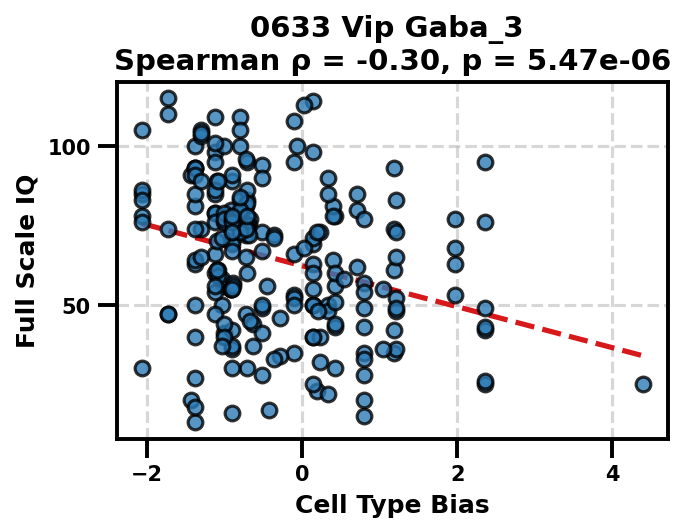

In [390]:
STR = "0623 Vip Gaba_1"
STR = "0633 Vip Gaba_3"
Plot_Bias_vs_IQ_MoustCT(STR, Mut_n_IQ_conf, Mouse_Z2_Mat)

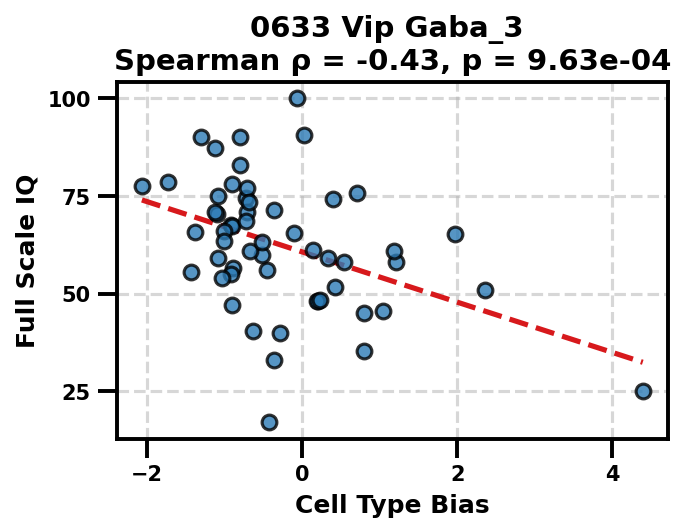

In [391]:
Plot_Bias_vs_IQ_MoustCT(STR, Avg_Gene_IQ_DF, Mouse_Z2_Mat)

In [368]:
ClusterAnn = pd.read_excel("../../data/Allen_Mouse_Brain_Cell_Atlas/SuppTables/41586_2023_6812_MOESM8_ESM.xlsx",
                          sheet_name = "cluster_annotation", index_col="cluster_id_label")

In [377]:
classes = ClusterAnn["class_label"].unique()

In [378]:
classes

array(['IT-ET Glut', 'NP-CT-L6b Glut', 'OB-CR Glut', 'DG-IMN Glut',
       'OB-IMN GABA', 'CTX-CGE GABA', 'CTX-MGE GABA', 'CNU-MGE GABA',
       'CNU-LGE GABA', 'CNU-HYa GABA', 'LSX GABA', 'HY GABA',
       'CNU-HYa Glut', 'HY Glut', 'HY Gnrh1 Glut', 'HY MM Glut',
       'MH-LH Glut', 'TH Glut', 'MB Glut', 'MB GABA', 'MB Dopa',
       'MB-HB Sero', 'P Glut', 'MY Glut', 'Pineal Glut', 'P GABA',
       'MY GABA', 'CB GABA', 'CB Glut', 'Astro-Epen', 'OPC-Oligo', 'OEC',
       'Vascular', 'Immune'], dtype=object)

In [430]:
names, supercluster, correlation, pvalues = [],[],[],[]
for STR in Mouse_Z2_Mat.columns.values:
    #print(STR, CT_Bias.loc[STR, "Supercluster"])
    biases, IQs = BiasVsPheno(Avg_Gene_IQ_DF, Mouse_Z2_Mat , STR, 'xx')
    pho, p = spearmanr(biases, IQs)
    #print(pho, p)
    names.append("{}".format(STR))
    supercluster.append(ClusterAnn.loc[STR, "class_label"])
    correlation.append(pho)
    pvalues.append(p)
mouse_ct_res_df_geneL = pd.DataFrame(data={"CT":names, "Supercluster":supercluster, "SpearmanR":correlation, "p":pvalues})
mouse_ct_res_df_geneL = mouse_ct_res_df_geneL.sort_values("SpearmanR")
mouse_ct_res_df_geneL = ADJ_P(mouse_ct_res_df_geneL)
mouse_ct_res_df_geneL.to_csv("../dat/Pheno_Bias_vs_IQ/MouseCT.GeneL.csv")

In [432]:
names, supercluster, correlation, pvalues = [],[],[],[]
for STR in Mouse_Z2_Mat.columns.values:
    #print(STR, CT_Bias.loc[STR, "Supercluster"])
    biases, IQs = BiasVsPheno(Mut_n_IQ_conf, Mouse_Z2_Mat , STR, 'xx')
    pho, p = spearmanr(biases, IQs)
    #print(pho, p)
    names.append("{}".format(STR))
    supercluster.append(ClusterAnn.loc[STR, "class_label"])
    correlation.append(pho)
    pvalues.append(p)
mouse_ct_res_df_mutL = pd.DataFrame(data={"CT":names, "Supercluster":supercluster, "SpearmanR":correlation, "p":pvalues})
mouse_ct_res_df_mutL = mouse_ct_res_df_mutL.sort_values("SpearmanR")
mouse_ct_res_df_mutL = ADJ_P(mouse_ct_res_df_mutL)
mouse_ct_res_df_mutL.to_csv("../dat/Pheno_Bias_vs_IQ/MouseCT.mutL.csv", index=False)

In [389]:
mouse_ct_res_df_geneL[mouse_ct_res_df_geneL["Supercluster"]=="CTX-CGE GABA"].head(50)

CT  Supercluster  SpearmanR         p
682          0684 Sncg Gaba_8  CTX-CGE GABA  -0.462388  0.000379
692  0694 RHP-COA Ndnf Gaba_3  CTX-CGE GABA  -0.450915  0.000551
697  0699 RHP-COA Ndnf Gaba_5  CTX-CGE GABA  -0.444637  0.000671
702  0704 RHP-COA Ndnf Gaba_6  CTX-CGE GABA  -0.442003  0.000729
701  0703 RHP-COA Ndnf Gaba_5  CTX-CGE GABA  -0.436916  0.000852
631           0633 Vip Gaba_3  CTX-CGE GABA  -0.432911  0.000963
700  0702 RHP-COA Ndnf Gaba_5  CTX-CGE GABA  -0.429700  0.001060
668          0670 Sncg Gaba_2  CTX-CGE GABA  -0.424180  0.001249
633           0635 Vip Gaba_3  CTX-CGE GABA  -0.415990  0.001585
687  0689 RHP-COA Ndnf Gaba_1  CTX-CGE GABA  -0.415305  0.001616
718         0720 Lamp5 Gaba_3  CTX-CGE GABA  -0.414006  0.001677
651           0653 Vip Gaba_8  CTX-CGE GABA  -0.412274  0.001762
653           0655 Vip Gaba_9  CTX-CGE GABA  -0.409460  0.001908
669          0671 Sncg Gaba_2  CTX-CGE GABA  -0.404156  0.002212
661          0663 Vip Gaba_12  CTX-CGE GABA  -0.396471  0.002730
683          0685 Sncg Gaba_8  CTX-CGE GABA  -0.394668  0.002866
680          0682 Sncg Gaba_6  CTX-CGE GABA  -0.394307  0.002894
720         0722 Lamp5 Gaba_4  CTX-CGE GABA  -0.393297  0.002973
693  0695 RHP-COA Ndnf Gaba_3  CTX-CGE GABA  -0.390518  0.003202
636           0638 Vip Gaba_4  CTX-CGE GABA  -0.388967  0.003336
642           0644 Vip Gaba_5  CTX-CGE GABA  -0.387307  0.003485
681          0683 Sncg Gaba_7  CTX-CGE GABA  -0.386550  0.003555
709         0711 Lamp5 Gaba_1  CTX-CGE GABA  -0.386153  0.003593
629           0631 Vip Gaba_2  CTX-CGE GABA  -0.385503  0.003654
703  0705 RHP-COA Ndnf Gaba_6  CTX-CGE GABA  -0.385395  0.003665
713         0715 Lamp5 Gaba_2  CTX-CGE GABA  -0.384962  0.003706
644           0646 Vip Gaba_6  CTX-CGE GABA  -0.379370  0.004284
706         0708 Lamp5 Gaba_1  CTX-CGE GABA  -0.375979  0.004671
670          0672 Sncg Gaba_3  CTX-CGE GABA  -0.375690  0.004705
649           0651 Vip Gaba_7  CTX-CGE GABA  -0.374716  0.004823
715         0717 Lamp5 Gaba_2  CTX-CGE GABA  -0.373345  0.004993
710         0712 Lamp5 Gaba_1  CTX-CGE GABA  -0.370892  0.005310
684  0686 RHP-COA Ndnf Gaba_1  CTX-CGE GABA  -0.369881  0.005446
717         0719 Lamp5 Gaba_3  CTX-CGE GABA  -0.369304  0.005524
672          0674 Sncg Gaba_3  CTX-CGE GABA  -0.367284  0.005808
641           0643 Vip Gaba_5  CTX-CGE GABA  -0.364578  0.006209
690  0692 RHP-COA Ndnf Gaba_2  CTX-CGE GABA  -0.360176  0.006911
674          0676 Sncg Gaba_3  CTX-CGE GABA  -0.357073  0.007447
632           0634 Vip Gaba_3  CTX-CGE GABA  -0.356388  0.007570
624           0626 Vip Gaba_1  CTX-CGE GABA  -0.355883  0.007662
708         0710 Lamp5 Gaba_1  CTX-CGE GABA  -0.355017  0.007822
688  0690 RHP-COA Ndnf Gaba_2  CTX-CGE GABA  -0.354331  0.007951
673          0675 Sncg Gaba_3  CTX-CGE GABA  -0.350759  0.008651
646           0648 Vip Gaba_6  CTX-CGE GABA  -0.349100  0.008994
637           0639 Vip Gaba_4  CTX-CGE GABA  -0.348883  0.009040
679          0681 Sncg Gaba_5  CTX-CGE GABA  -0.348450  0.009132
719         0721 Lamp5 Gaba_3  CTX-CGE GABA  -0.348342  0.009155
675          0677 Sncg Gaba_3  CTX-CGE GABA  -0.347079  0.009428
638           0640 Vip Gaba_5  CTX-CGE GABA  -0.346358  0.009587
621           0623 Vip Gaba_1  CTX-CGE GABA  -0.345420  0.009797

In [386]:
mouse_ct_res_df_geneL.head(20)

CT  Supercluster  SpearmanR         p
759                   0761 Sst Gaba_1  CTX-MGE GABA  -0.585200  0.000003
795                   0797 Sst Gaba_8  CTX-MGE GABA  -0.532128  0.000029
756                   0758 Sst Gaba_1  CTX-MGE GABA  -0.525418  0.000038
2017  2019 COAa-PAA-MEA Barhl2 Glut_1  CNU-HYa Glut  -0.524335  0.000040
816                  0818 Sst Gaba_16  CTX-MGE GABA  -0.497998  0.000109
779                   0781 Sst Gaba_5  CTX-MGE GABA  -0.490421  0.000144
796                   0798 Sst Gaba_9  CTX-MGE GABA  -0.487282  0.000161
1211         1213 MEA-BST Sox6 Gaba_5  CNU-HYa GABA  -0.479886  0.000209
2697           2699 RE-Xi Nox4 Glut_3       TH Glut  -0.477252  0.000229
758                   0760 Sst Gaba_1  CTX-MGE GABA  -0.476675  0.000234
754                   0756 Sst Gaba_1  CTX-MGE GABA  -0.474655  0.000251
682                  0684 Sncg Gaba_8  CTX-CGE GABA  -0.462388  0.000379
804                  0806 Sst Gaba_11  CTX-MGE GABA  -0.458130  0.000436
777                   0779 Sst Gaba_4  CTX-MGE GABA  -0.451456  0.000541
692          0694 RHP-COA Ndnf Gaba_3  CTX-CGE GABA  -0.450915  0.000551
697          0699 RHP-COA Ndnf Gaba_5  CTX-CGE GABA  -0.444637  0.000671
702          0704 RHP-COA Ndnf Gaba_6  CTX-CGE GABA  -0.442003  0.000729
2694           2696 RE-Xi Nox4 Glut_2       TH Glut  -0.441462  0.000741
762                   0764 Sst Gaba_2  CTX-MGE GABA  -0.440885  0.000755
808                  0810 Sst Gaba_13  CTX-MGE GABA  -0.440271  0.000769

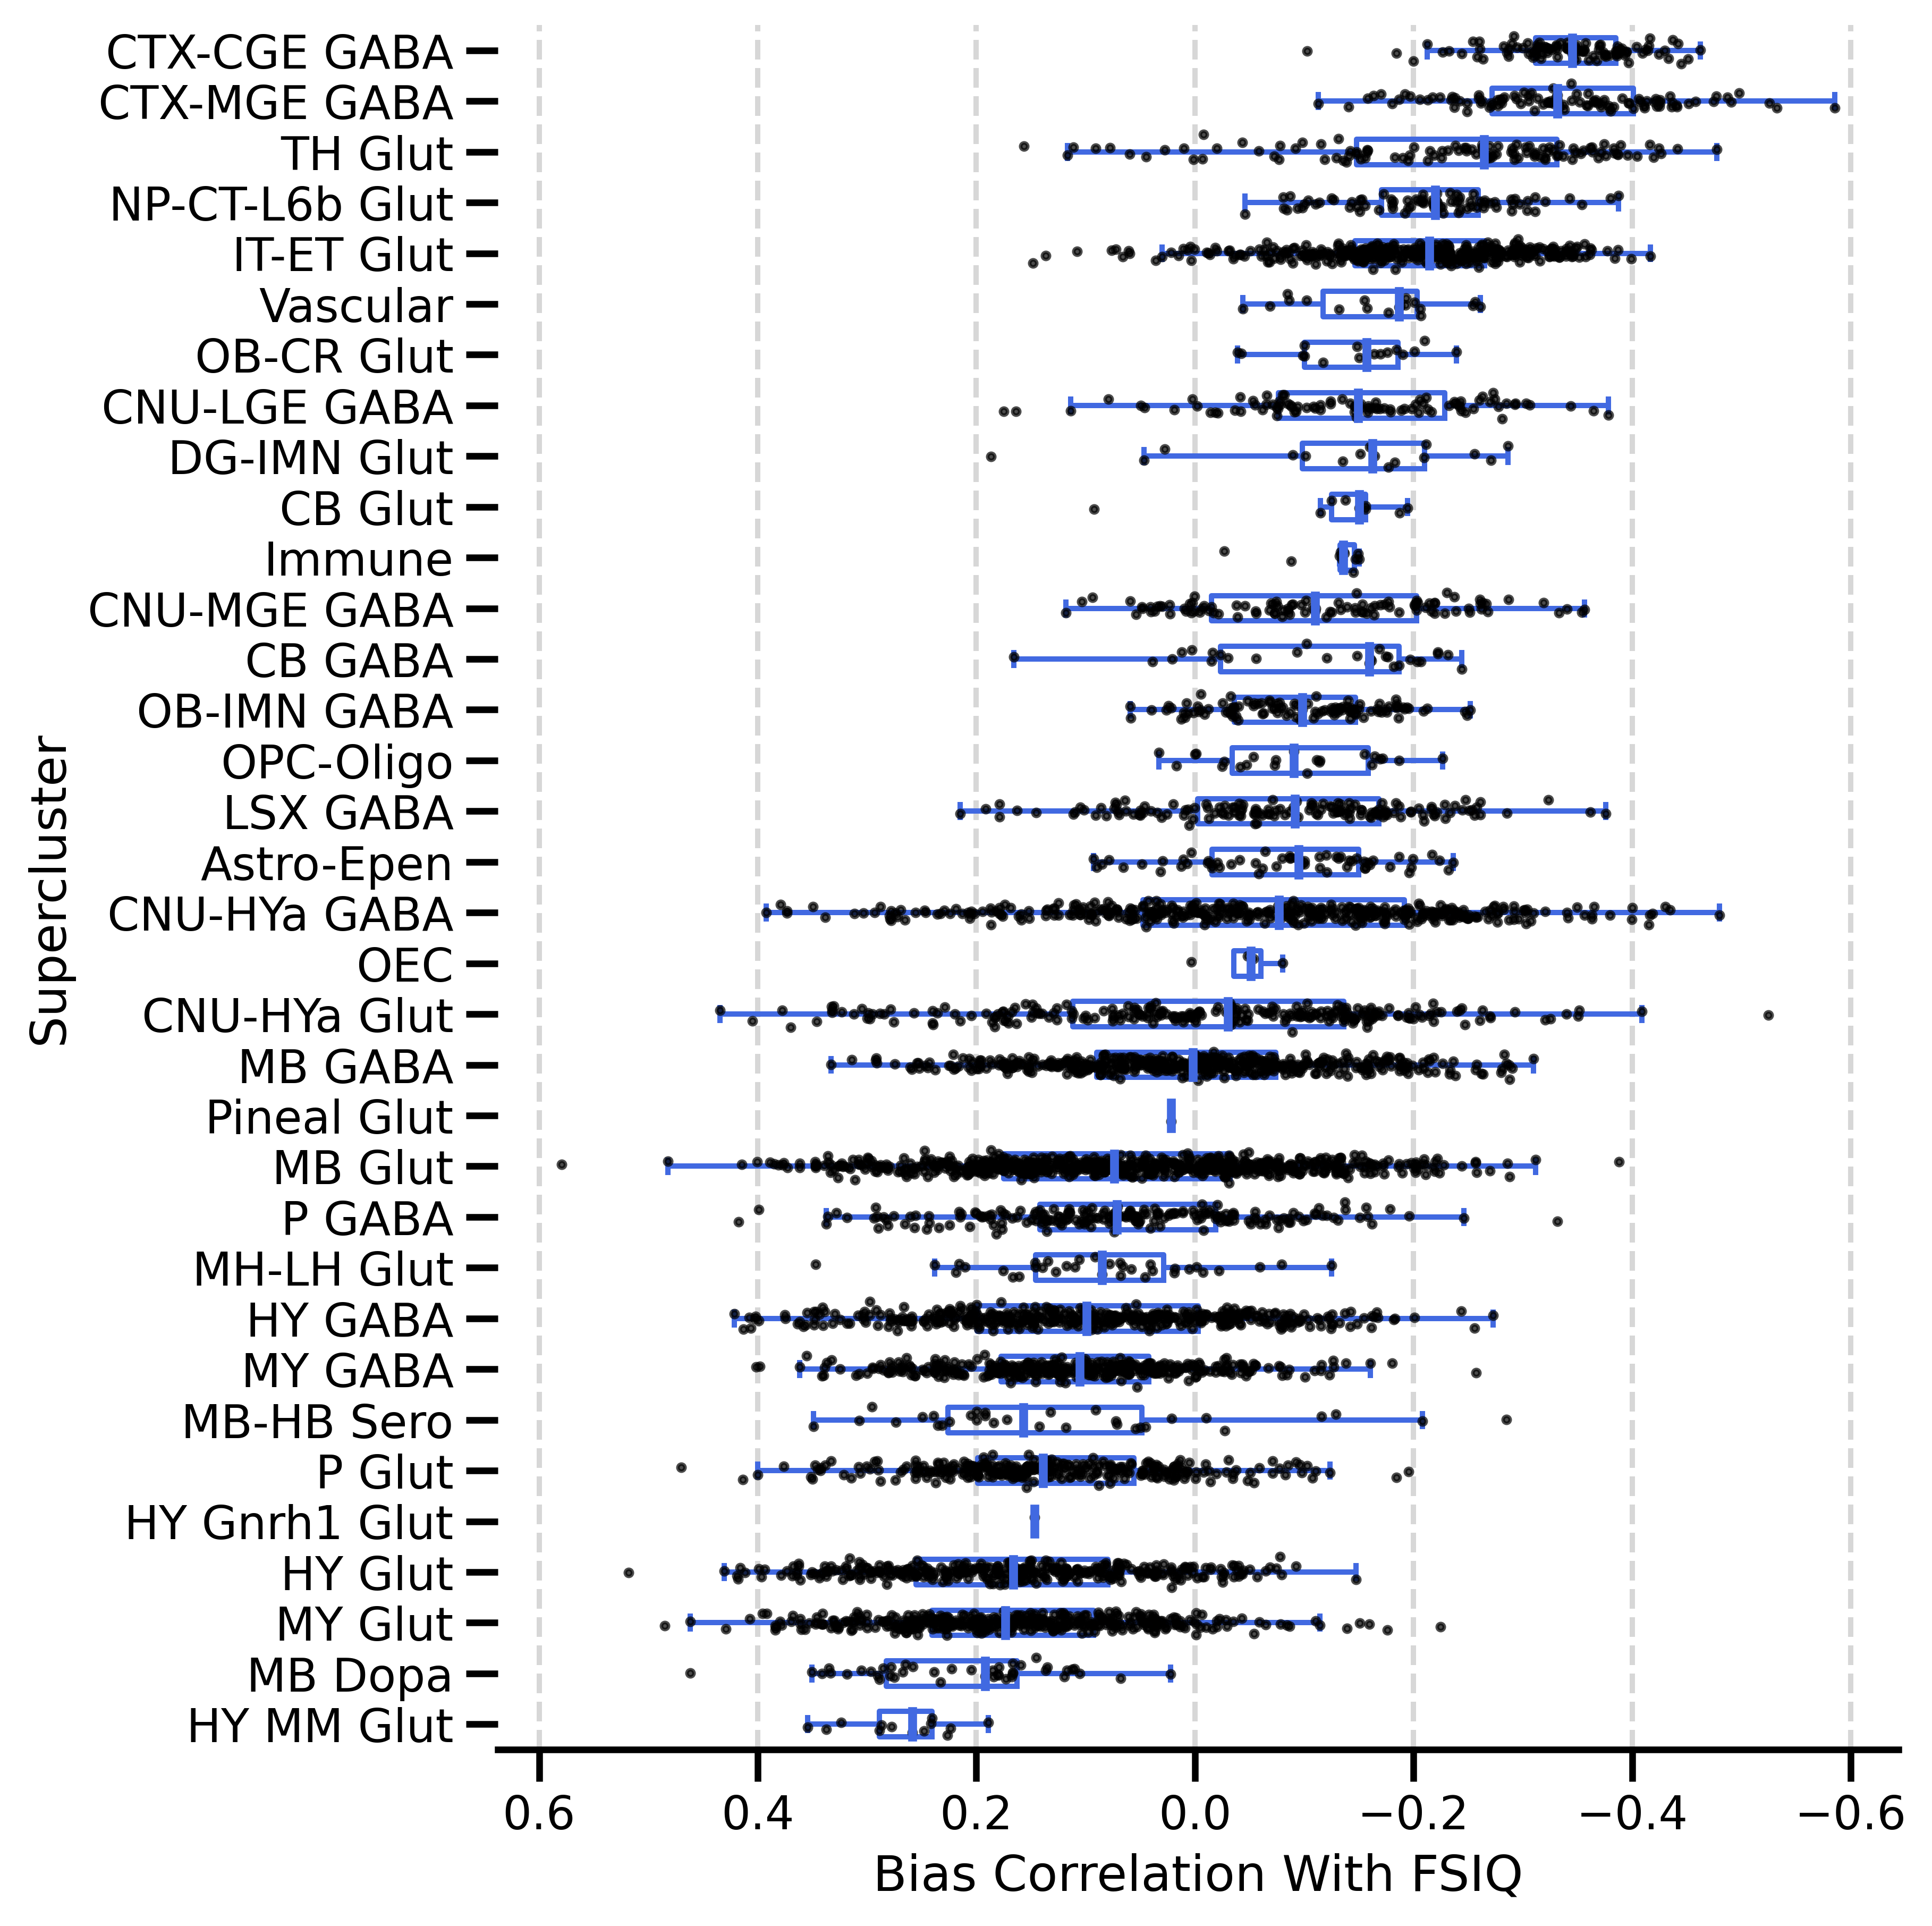

In [392]:
def SuperClusterBias_BoxPlot_CorrIQ(DF1, classes):
    dat_Z2 = []
    mean_Z2 = []
    for _CT in classes:
        tmp = DF1[DF1["Supercluster"] == _CT]
        dat_Z2.append(tmp["SpearmanR"].values)
        mean_Z2.append(np.mean(tmp["SpearmanR"].values))
    mean_Z2 = np.array(mean_Z2)

    # Sorting data by the mean values
    sort_idx = np.argsort(mean_Z2)[::-1]  # Reverse the sorting order
    show_dat_Z2 = [dat_Z2[x] for x in sort_idx]
    show_CTs = [classes[x] for x in sort_idx]

    # Create a figure and axis
    fig, ax = plt.subplots(dpi=480, figsize=(8, 8))

    # Customize the boxplot to only show the edges with the same color
    boxprops = dict(linestyle='-', linewidth=1.5, color='royalblue')
    medianprops = dict(linestyle='-', linewidth=2.5, color='royalblue')
    whiskerprops = dict(color='royalblue', linewidth=1.5)
    capprops = dict(color='royalblue', linewidth=1.5)
    flierprops = dict(marker='', color='royalblue', alpha=0.5)  # Adjusted to not show outliers

    # Use Seaborn to set the context for publication-quality plots
    sns.set_context("talk", font_scale=1.2)

    # Draw the boxplot
    bp = ax.boxplot(show_dat_Z2, labels=show_CTs, vert=False, patch_artist=False,
                    boxprops=boxprops, medianprops=medianprops, 
                    whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops)

    # Overlay each data point on the boxplot
    for i in range(len(show_dat_Z2)):
        y = np.random.normal(i + 1, 0.1, size=len(show_dat_Z2[i]))  # jitter for better visibility
        ax.plot(show_dat_Z2[i], y, 'o', markersize=2, color='black', alpha=0.7)

    # Add grid lines
    ax.grid(True, axis='x', linestyle='--', alpha=0.6)

    # Add labels and title
    ax.set_xlabel("Bias Correlation With FSIQ", fontsize=14)
    ax.set_ylabel("Supercluster", fontsize=14)

    # Flip the x-axis
    ax.invert_xaxis()

    # Adjust the tick parameters for better readability
    ax.tick_params(axis='both', which='major', labelsize=13, grid_alpha=0.5)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage with your DataFrames DF1 and DF2
SuperClusterBias_BoxPlot_CorrIQ(mouse_ct_res_df_geneL, classes)


### Mouse STR Data

In [402]:
Mouse_STR_Z2_Mat = pd.read_csv("../../ASD_Circuits/dat/allen-mouse-exp/AllenMouseBrain_Z2bias.csv", index_col=0)

In [405]:
def Plot_Bias_vs_IQ_MoustSTR(STR, Mut_n_IQ_conf=Mut_n_IQ_conf, HCT_Z2_MAT_HCT = HCT_Z2_MAT_HCT):
    biases, IQs = BiasVsPheno(Mut_n_IQ_conf, HCT_Z2_MAT_HCT , STR, 'XX')
    pho, p = spearmanr(biases, IQs)
    # Create the scatter plot
    plt.figure(dpi=150, figsize=(5, 4))

    # Plot data points
    plt.scatter(biases, IQs, s=50, color="#2c7bb6", edgecolor="black", alpha=0.8, zorder=10)

    # Fit and plot the trend line
    b, a = np.polyfit(biases, IQs, deg=1)
    xseq = np.linspace(min(biases), max(biases), num=100)
    plt.plot(xseq, a + b * xseq, color="#d7191c", lw=2.5, linestyle='--', zorder=5)
    #_SuperCluster = Anno.loc[STR, "Supercluster"]
    # Add title with improved formatting
    #plt.title(f'{_SuperCluster} - {STR} \nSpearman ρ = {pho:.2f}, p = {p:.2e}', fontsize=14, fontweight='bold')
    plt.title(f'{STR} \nSpearman ρ = {pho:.2f}, p = {p:.2e}', fontsize=14, fontweight='bold')

    # Labeling axes
    plt.xlabel("STR Bias", fontsize=12, fontweight='bold')
    plt.ylabel("Full Scale IQ", fontsize=12, fontweight='bold')

    # Grid lines for better readability
    plt.grid(True, linestyle='--', alpha=0.5)

    # Adjust tick parameters
    plt.xticks(fontsize=10, fontweight='bold')
    plt.yticks(fontsize=10, fontweight='bold')

    # Tight layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

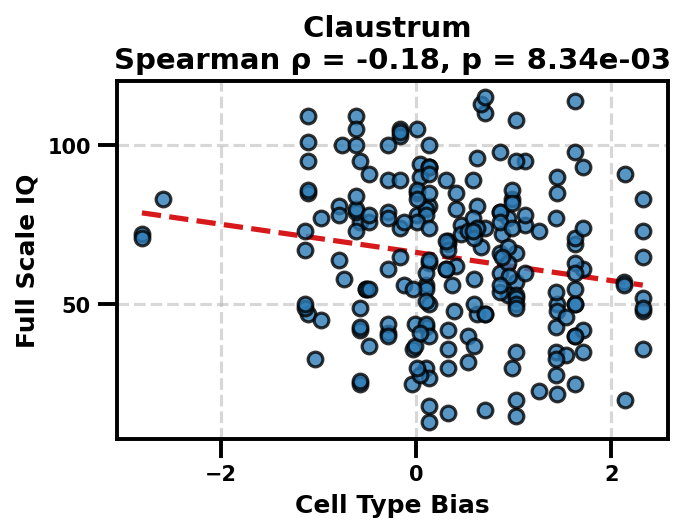

In [406]:
STR = "Claustrum"
#STR = "0633 Vip Gaba_3"
Plot_Bias_vs_IQ_MoustCT(STR, Mut_n_IQ_conf, Mouse_STR_Z2_Mat)

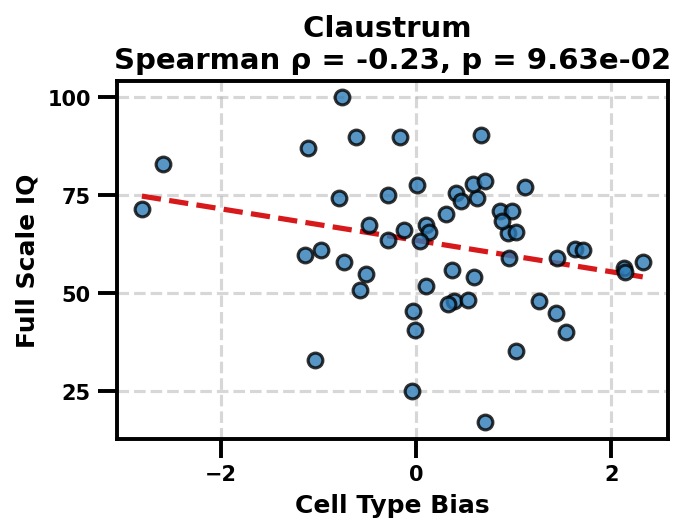

In [407]:
Plot_Bias_vs_IQ_MoustCT(STR, Avg_Gene_IQ_DF, Mouse_STR_Z2_Mat)

In [414]:
STR_Ann = pd.read_csv("/home/jw3514/Work/ASD_Circuits/dat/structure2region.tsv", delimiter="\t", index_col=0)

In [415]:
STR_Ann

REG
STR                                                       
Dentate_gyrus                                  Hippocampus
Accessory_olfactory_bulb                   Olfactory_areas
Field_CA3                                      Hippocampus
Retrosplenial_area_lateral_agranular_part        Isocortex
Field_CA1                                      Hippocampus
...                                                    ...
Facial_motor_nucleus                               Medulla
Nucleus_ambiguus                                   Medulla
Ventral_cochlear_nucleus                           Medulla
Nucleus_raphe_magnus                               Medulla
Subiculum                                      Hippocampus

[214 rows x 1 columns]

In [427]:
names, supercluster, correlation, pvalues = [],[],[],[]
for STR in Mouse_STR_Z2_Mat.columns.values:
    #print(STR, CT_Bias.loc[STR, "Supercluster"])
    biases, IQs = BiasVsPheno(Mut_n_IQ_conf, Mouse_STR_Z2_Mat , STR, 'xx')
    pho, p = spearmanr(biases, IQs)
    #print(pho, p)
    names.append("{}".format(STR))
    supercluster.append(STR_Ann.loc[STR, "REG"])
    correlation.append(pho)
    pvalues.append(p)
mouse_str_res_df_MutL = pd.DataFrame(data={"CT":names, "Region":supercluster, "SpearmanR":correlation, "p":pvalues})
mouse_str_res_df_MutL = mouse_str_res_df_MutL.sort_values("SpearmanR")
mouse_str_res_df_MutL = ADJ_P(mouse_str_res_df_MutL)
mouse_str_res_df_MutL.to_csv("../dat/Pheno_Bias_vs_IQ/MouseSTR.MutL.csv")

In [429]:
names, supercluster, correlation, pvalues = [],[],[],[]
for STR in Mouse_STR_Z2_Mat.columns.values:
    #print(STR, CT_Bias.loc[STR, "Supercluster"])
    biases, IQs = BiasVsPheno(Avg_Gene_IQ_DF, Mouse_STR_Z2_Mat , STR, 'xx')
    pho, p = spearmanr(biases, IQs)
    #print(pho, p)
    names.append("{}".format(STR))
    supercluster.append(STR_Ann.loc[STR, "REG"])
    correlation.append(pho)
    pvalues.append(p)
mouse_str_res_df_geneL = pd.DataFrame(data={"CT":names, "Region":supercluster, "SpearmanR":correlation, "p":pvalues})
mouse_str_res_df_geneL = mouse_str_res_df_geneL.sort_values("SpearmanR")
mouse_str_res_df_geneL = ADJ_P(mouse_str_res_df_geneL)
mouse_str_res_df_geneL.to_csv("../dat/Pheno_Bias_vs_IQ/MouseSTR.GeneL.csv")

In [424]:
def ADJ_P(DF):
    _, q = stats.multitest.fdrcorrection(DF["p"].values)
    DF["p_adj"] = q
    return DF

In [425]:
mouse_str_res_df_geneL = ADJ_P(mouse_str_res_df_geneL)

In [426]:
mouse_str_res_df_geneL.head(50)

CT             Region  \
189                     Temporal_association_areas          Isocortex   
111                       Orbital_area_medial_part          Isocortex   
62                                Infralimbic_area          Isocortex   
45                                 Ectorhinal_area          Isocortex   
114                    Posterior_amygdalar_nucleus           Amygdala   
185                         Subiculum_ventral_part        Hippocampus   
68                       Lateral_amygdalar_nucleus           Amygdala   
24                                       Field_CA1        Hippocampus   
129                                 Prelimbic_area          Isocortex   
193                                   Taenia_tecta    Olfactory_areas   
1              Anterior_cingulate_area_dorsal_part          Isocortex   
184                          Subiculum_dorsal_part        Hippocampus   
43                          Dorsal_peduncular_area    Olfactory_areas   
88           Medial_geniculate_complex_dorsal_part           Thalamus   
49               Endopiriform_nucleus_ventral_part  Cortical_subplate   
40                                   Dentate_gyrus        Hippocampus   
3                                Nucleus_accumbens           Striatum   
71   Dorsal_part_of_the_lateral_geniculate_complex           Thalamus   
25                                       Field_CA2        Hippocampus   
21                   Basolateral_amygdalar_nucleus           Amygdala   
48                Endopiriform_nucleus_dorsal_part  Cortical_subplate   
201                       Anteromedial_visual_area          Isocortex   
112                Orbital_area_ventrolateral_part          Isocortex   
30                                       Claustrum  Cortical_subplate   
179                Primary_somatosensory_area_nose          Isocortex   
204                     Posterolateral_visual_area          Isocortex   
178               Primary_somatosensory_area_mouth          Isocortex   
143           Posterior_parietal_association_areas          Isocortex   
90          Medial_geniculate_complex_ventral_part           Thalamus   
133                                  Postsubiculum        Hippocampus   
89           Medial_geniculate_complex_medial_part           Thalamus   
205                      posteromedial_visual_area          Isocortex   
6               Agranular_insular_area_dorsal_part          Isocortex   
26                                       Field_CA3        Hippocampus   
2             Anterior_cingulate_area_ventral_part          Isocortex   
128                                  Piriform_area    Olfactory_areas   
122                         Parafascicular_nucleus           Thalamus   
17                            Dorsal_auditory_area          Isocortex   
190                   Postpiriform_transition_area    Olfactory_areas   
57                                 Gustatory_areas          Isocortex   
95                            Secondary_motor_area          Isocortex   
202                            Lateral_visual_area          Isocortex   
47         Entorhinal_area_medial_part_dorsal_zone        Hippocampus   
22                    Basomedial_amygdalar_nucleus           Amygdala   
136                                   Presubiculum        Hippocampus   
200                      Anterolateral_visual_area          Isocortex   
75       Lateral_posterior_nucleus_of_the_thalamus           Thalamus   
117                                  Parasubiculum        Hippocampus   
180               Primary_somatosensory_area_trunk          Isocortex   
35                                    Caudoputamen           Striatum   

     SpearmanR         p     p_adj  
189  -0.368799  0.005594  0.122216  
111  -0.363459  0.006381  0.122216  
62   -0.358408  0.007212  0.122216  
45   -0.357001  0.007460  0.122216  
114  -0.331926  0.013297  0.149541  
185  -0.331782  0.013339  0.149541  
68   -0.310640  0.020984  0.195638  
24   -0.310315  0.021125  0.

#### OldM

In [195]:
ExpL = pd.read_csv("../dat/HumanCTExpressionMats/Human.CT.Exp.Entrez.log2.csv", index_col=0)
ExpL.columns = [int(x) for x in ExpL.columns.values ]
#CT_Z2_Mat = pd.read_csv("../dat/HumanCTExpressionMats/Human.CT.Exp.Entrez.log2.Z2.HCT.csv",index_col=0)
CT_Z2_Mat = pd.read_csv("../dat/HumanCTExpressionMats/Human.CT.Exp.Entrez.log2.Z2.HCT.z1clip3.csv",index_col=0)
max_Z, min_Z = 3, -3
CT_Z2_Mat = CT_Z2_Mat.clip(upper=max_Z, lower=min_Z)
CT_Z2_Mat.columns = [int(x) for x in CT_Z2_Mat.columns.values ]

In [205]:
HighConfMuts_wIQ.shape

(221, 47)

In [196]:
HighConfMuts_wIQ = pd.read_csv("../notebooks2/HighConfMuts_wIQ.csv")
def BiasVsPheno(MutPhenoDF, BiasMat, STR, label):
    biases = []
    IQs = []
    for i, row in MutPhenoDF.iterrows():
        if label == 'label':
            gene = row["HGNC"]
        else:
            gene = int(row["EntrezID"])
        if gene in BiasMat.index.values:
            bias = BiasMat.loc[gene, STR]
            if bias == bias:
                IQ = row["FSIQ"]
                biases.append(bias)
                IQs.append(IQ)
    return biases, IQs

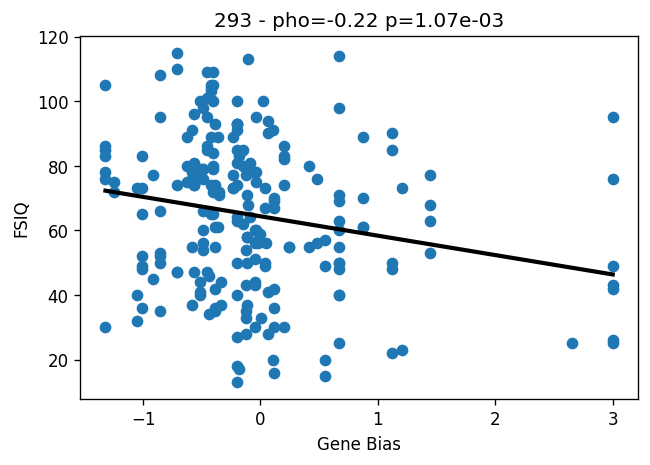

In [197]:
STR = 293
plt.figure(dpi=120)
biases, IQs = BiasVsPheno(HighConfMuts_wIQ, CT_Z2_Mat , STR , 'xx')
#print(biases, IQs)
pho, p = spearmanr(biases, IQs)
plt.scatter(biases, IQs)
b, a = np.polyfit(biases, IQs, deg=1)
xseq = np.linspace(min(biases), max(biases), num=100)
plt.plot(xseq, a + b * xseq, color="k", lw=2.5);

plt.title('%s - pho=%.2f p=%.2e' % (STR, pho, p))
plt.xlabel("Gene Bias")
plt.ylabel("FSIQ")
plt.show() 

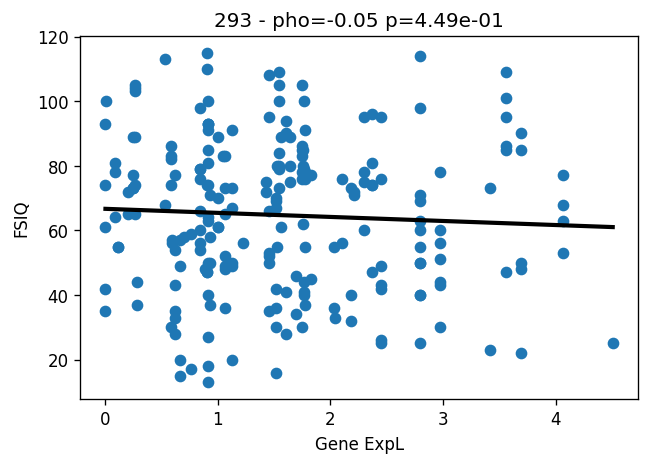

In [198]:
STR = 293
plt.figure(dpi=120)
biases, IQs = BiasVsPheno(HighConfMuts_wIQ, ExpL , STR , 'xx')
#print(biases, IQs)
pho, p = spearmanr(biases, IQs)
plt.scatter(biases, IQs)
b, a = np.polyfit(biases, IQs, deg=1)
xseq = np.linspace(min(biases), max(biases), num=100)
plt.plot(xseq, a + b * xseq, color="k", lw=2.5);

plt.title('%s - pho=%.2f p=%.2e' % (STR, pho, p))
plt.xlabel("Gene ExpL")
plt.ylabel("FSIQ")
plt.show() 

In [199]:
Neuron_idx = Anno[Anno["Supercluster"].isin(Neurons)].index.values

In [200]:
names, correlation, pvalues = [],[],[]
for STR in Neuron_idx:    #Neuron_idx
    biases, IQs = BiasVsPheno(HighConfMuts_wIQ, CT_Z2_Mat , STR, 'xx')
    pho, p = spearmanr(biases, IQs)
    names.append("{}- {}".format(STR, Anno.loc[STR, "Supercluster"]))
    correlation.append(pho)
    pvalues.append(p)

In [201]:
ct_res_df = pd.DataFrame(data={"CT":names, "SpearmanR":correlation, "p":pvalues})
ct_res_df = ct_res_df.sort_values("SpearmanR")
ct_res_df.head(2)

CT  SpearmanR         p
188  267- LAMP5-LHX6 and Chandelier  -0.277066  0.000029
187  266- LAMP5-LHX6 and Chandelier  -0.264943  0.000067

In [202]:
_, q = stats.multitest.fdrcorrection(ct_res_df["p"].values)
ct_res_df["p_adj"] = q

In [203]:
ct_res_df.head(20)

CT  SpearmanR         p     p_adj
188  267- LAMP5-LHX6 and Chandelier  -0.277066  0.000029  0.008491
187  266- LAMP5-LHX6 and Chandelier  -0.264943  0.000067  0.008491
197            276- CGE interneuron  -0.236066  0.000401  0.038266
186  265- LAMP5-LHX6 and Chandelier  -0.230256  0.000560  0.039243
214            293- CGE interneuron  -0.218669  0.001068  0.049945
216            295- CGE interneuron  -0.216873  0.001177  0.049945
189  268- LAMP5-LHX6 and Chandelier  -0.210757  0.001628  0.052954
217            296- CGE interneuron  -0.210735  0.001630  0.052954
215            294- CGE interneuron  -0.208458  0.001835  0.052954
190  269- LAMP5-LHX6 and Chandelier  -0.204759  0.002219  0.052989
185  264- LAMP5-LHX6 and Chandelier  -0.193769  0.003832  0.081316
233          312- Upper rhombic lip  -0.191425  0.004289  0.081928
230          309- Upper rhombic lip  -0.177038  0.008344  0.121252
198            277- CGE interneuron  -0.173696  0.009675  0.131999
207            286- CGE interneuron  -0.172554  0.010171  0.132692
194  273- LAMP5-LHX6 and Chandelier  -0.171997  0.010421  0.132692
160            239- MGE interneuron  -0.169000  0.011861  0.141595
213            292- CGE interneuron  -0.159411  0.017713  0.169160
205            284- CGE interneuron  -0.158085  0.018694  0.174171
232          311- Upper rhombic lip  -0.156803  0.019687  0.179054

In [ ]:
# Gene LeveL


# Bipolar

In [3]:
df = pd.read_csv("../../data/Bipolar/Bipolar_gene_res.tsv", sep="\t")
df1 = df[df["group"]=="Bipolar Disorder"]
df2 = df[df["group"]=="Bipolar Disorder (including Schizoaffective)"]
print(df.shape, df2.shape)

(119958, 20) (19993, 20)


In [4]:
# Annotate genes and combine p from dmis and PTV
for i, row in df1.iterrows():
    gene_id = row["gene_id"]
    gene_entrez = ENSID2Entrez.get(gene_id, 0)
    gene_symbol = Entrez2Symbol.get(gene_entrez, ".")
    ncase = row["n_cases"]
    ncont = row["n_controls"]
    df1.loc[i, "EntrezID"] = gene_entrez
    df1.loc[i, "Symbol"] = gene_symbol
    #print(gene_entrez, gene_symbol)
    _, fisherP = scipy.stats.combine_pvalues([row["damaging_missense_fisher_gnom_non_psych_pval"], 
                                    row["ptv_fisher_gnom_non_psych_pval"]])
    #print(fisherP)
    Eff_LGD = row["ptv_case_count"] - row["ptv_control_count"]/ncont*ncase
    Eff_Dmis = row["damaging_missense_case_count"] - row["damaging_missense_control_count"]/ncont*ncase
    df1.loc[i, "Pcombine"] = fisherP
    df1.loc[i, "Effect.LGD"] = max(0, Eff_LGD)
    df1.loc[i, "Effect.Dmis"] = max(0, Eff_Dmis)
df1 = df1.sort_values("Pcombine", ascending=True)
df1 = df1[(df1["Effect.LGD"]>0) | (df1["Effect.Dmis"]>0)]
df1["EntrezID"] = [int(x) for x in df1["EntrezID"].values]
df1.to_csv("../dat/bipolar.genes.modified.csv")

/tmp/ipykernel_76362/4217726819.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[i, "EntrezID"] = gene_entrez
/tmp/ipykernel_76362/4217726819.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[i, "Symbol"] = gene_symbol
/tmp/ipykernel_76362/4217726819.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [5]:
# Annotate genes and combine p from dmis and PTV
for i, row in df2.iterrows():
    gene_id = row["gene_id"]
    gene_entrez = ENSID2Entrez.get(gene_id, 0)
    gene_symbol = Entrez2Symbol.get(gene_entrez, ".")
    ncase = row["n_cases"]
    ncont = row["n_controls"]
    df2.loc[i, "EntrezID"] = gene_entrez
    df2.loc[i, "Symbol"] = gene_symbol
    #print(gene_entrez, gene_symbol)
    _, fisherP = scipy.stats.combine_pvalues([row["damaging_missense_fisher_gnom_non_psych_pval"], 
                                    row["ptv_fisher_gnom_non_psych_pval"]])
    #print(fisherP)
    Eff_LGD = row["ptv_case_count"] - row["ptv_control_count"]/ncont*ncase
    Eff_Dmis = row["damaging_missense_case_count"] - row["damaging_missense_control_count"]/ncont*ncase
    df2.loc[i, "Pcombine"] = fisherP
    df2.loc[i, "Effect.LGD"] = max(0, Eff_LGD)
    df2.loc[i, "Effect.Dmis"] = max(0, Eff_Dmis)
df2 = df2.sort_values("Pcombine", ascending=True)
df2 = df2[(df2["Effect.LGD"]>0) | (df2["Effect.Dmis"]>0)]
df2["EntrezID"] = [int(x) for x in df2["EntrezID"].values]
df2.to_csv("../dat/bipolar.wscz.genes.modified.csv")

/tmp/ipykernel_76362/980332554.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[i, "EntrezID"] = gene_entrez
/tmp/ipykernel_76362/980332554.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[i, "Symbol"] = gene_symbol
/tmp/ipykernel_76362/980332554.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [6]:
BP_topG = df2.head(61)["Symbol"].values
BP_top100G = df2.head(100)["Symbol"].values
BP_top200G = df2.head(200)["Symbol"].values

In [71]:
BP_topG

array(['AKAP11', 'DOP1A', 'THSD7A', 'PAMR1', 'NBPF14', 'SYDE2', 'KDM5B',
       'PLPPR3', 'AXIN1', 'TICRR', 'NPHP3', 'BBS9', 'FRMPD2', 'ATP9A',
       'PDLIM3', 'IL16', 'SHANK1', 'PNKP', 'CYP2A13', 'SLC10A6', 'TOPAZ1',
       'NTN4', 'MINDY4B', 'POLR3GL', 'CHST13', 'PROM2', 'LOXL4', 'CHRNB2',
       'TMEM235', 'HDGFL2', 'PANX2', 'ALG10', 'ZNF736', 'TET2', 'ARHGAP5',
       'ATP2C1', 'DNAI4', 'SORCS1', 'NEK1', 'HHIPL1', 'COMTD1', 'HECTD2',
       'GPRC5A', 'ALOX15', 'RFX8', 'KRTAP10-5', 'CHD1L', 'AEBP1',
       'KLHL33', 'PTCH2', 'FOLH1', 'CCNE2', 'EIF3A', 'GIGYF1', 'TNIK',
       'ABHD11', 'BTBD16', 'ZNF786', 'TMPRSS3', 'GDF9', 'RGPD8'],
      dtype=object)

In [67]:
ASD_SCZ_DF = pd.read_csv("GeneFuncs_ASD_SCZ-NetBag.tsv", sep="\t")

In [73]:
SCZ_Symbols = ASD_SCZ_DF[ASD_SCZ_DF["SCZ"]==1]["Gene"].values
ASD_Symbols = ASD_SCZ_DF[ASD_SCZ_DF["ASD"]==1]["Gene"].values

In [74]:
set(SCZ_Symbols).intersection(set(BP_topG))

{'AKAP11', 'ATP9A'}

In [75]:
set(ASD_Symbols).intersection(set(BP_topG))

{'GIGYF1', 'KDM5B'}

In [81]:
BP_topG

array(['ABHD11', 'AEBP1', 'AKAP11', 'ALG10', 'ALOX15', 'ARHGAP5',
       'ATP2C1', 'ATP9A', 'AXIN1', 'BBS9', 'BTBD16', 'CCNE2', 'CHD1L',
       'CHRNB2', 'CHST13', 'COMTD1', 'CYP2A13', 'DNAI4', 'DOP1A', 'EIF3A',
       'FOLH1', 'FRMPD2', 'GDF9', 'GIGYF1', 'GPRC5A', 'HDGFL2', 'HECTD2',
       'HHIPL1', 'IL16', 'KDM5B', 'KLHL33', 'KRTAP10-5', 'LOXL4',
       'MINDY4B', 'NBPF14', 'NEK1', 'NPHP3', 'NTN4', 'PAMR1', 'PANX2',
       'PDLIM3', 'PLPPR3', 'PNKP', 'POLR3GL', 'PROM2', 'PTCH2', 'RFX8',
       'RGPD8', 'SHANK1', 'SLC10A6', 'SORCS1', 'SYDE2', 'TET2', 'THSD7A',
       'TICRR', 'TMEM235', 'TMPRSS3', 'TNIK', 'TOPAZ1', 'ZNF736',
       'ZNF786'], dtype=object)

In [8]:
CT_Z2_MAT_HC = pd.read_csv("../dat/HumanCellType.AllCell.HCT.Z2bias.entrez.csv", index_col=0)
CT_Z2_MAT_HC.columns = [int(x) for x in CT_Z2_MAT_HC.columns.values]

In [9]:
Bipolar_GW1 = Aggregate_Gene_Weights_Bipolar(df1.head(61), CT_Z2_MAT_HC.index.values)
Bipolar_GW2 = Aggregate_Gene_Weights_Bipolar(df2.head(61), CT_Z2_MAT_HC.index.values)

Bipolar_100GW = Aggregate_Gene_Weights_Bipolar(df1.head(100), CT_Z2_MAT_HC.index.values)
Bipolar_200GW2 = Aggregate_Gene_Weights_Bipolar(df1.head(200), CT_Z2_MAT_HC.index.values)

79819 not in allen mouse dataset
79819 not in allen mouse dataset
79819 not in allen mouse dataset
642517 not in allen mouse dataset
79819 not in allen mouse dataset
642517 not in allen mouse dataset
0 not in allen mouse dataset
0 not in allen mouse dataset


In [10]:
Dict2Fil(Bipolar_GW1, "../dat/Bipolar.top61.gw.csv")
Dict2Fil(Bipolar_GW2, "../dat/Bipolar.2.top61.gw.csv")
Dict2Fil(Bipolar_100GW, "../dat/Bipolar.top100.gw.csv")
Dict2Fil(Bipolar_200GW2, "../dat/Bipolar.top200.gw.csv")

# NDD

In [ ]:
Spark_Meta_1stage = pd.read_excel("~/Work/SPARK2020/TabS_DenovoWEST_Stage1.xlsx",
                           skiprows=1, sheet_name="AllGenes")
Spark_Meta_1stage.shape

# Epi25

In [79]:
Epi25DF = pd.read_excel("../../data/Epilepsy/1-s2.0-S0002929721001403-mmc2.xlsx", 
                        sheet_name="S17 All Epi Deleterious")

In [80]:
#Epi25DF.columns.values

In [81]:
# 'Missense.Case', 'PTV.Case', 'Missense.Ctrl', 'PTV.Ctrl'

In [82]:
Epi25DF = Epi25DF[Epi25DF["estimate"]>1]
for i, row in Epi25DF.iterrows():
    symbol = Epi25DF.loc[i, "gene"].strip("''")
    Epi25DF.loc[i, "gene"] = symbol
    try:
        Epi25DF.loc[i, "Entrez"] = int(GeneSymbol2Entrez[symbol])
    except:
        Epi25DF.loc[i, "Entrez"] = None
    try:
        Epi25DF.loc[i, "pLI"] = ExAC_pLI.loc[symbol, "pLI"]
    except:
        Epi25DF.loc[i, "pLI"] = 0
    Epi25DF.loc[i, "nLGD"] = ModifyMutCount(Epi25DF.loc[i, "PTV.Case"], 
                                    Epi25DF.loc[i, "PTV.Ctrl"], 0, CaseN=13487, ContN=15678) 
    Epi25DF.loc[i, "nMis"] = ModifyMutCount(Epi25DF.loc[i, "Missense.Case"], 
                                    Epi25DF.loc[i, "Missense.Ctrl"], 0, CaseN=13487, ContN=15678) 
    
Epi25DF = Epi25DF.dropna(subset="Entrez")
Epi25DF_Filt = Epi25DF[["gene", "Entrez", "pLI", "nLGD", "nMis"]]
Epi25DF_Filt["Entrez"] = [int(x) for x in Epi25DF_Filt["Entrez"].values]
Epi25DF_Filt = Epi25DF_Filt.set_index("Entrez")
Epi25DF_Filt.shape

/tmp/ipykernel_76362/3599274987.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Epi25DF_Filt["Entrez"] = [int(x) for x in Epi25DF_Filt["Entrez"].values]


(79, 4)

In [83]:
Epi25DF_Filt.head(10)

gene  pLI      nLGD       nMis
Entrez                                  
6323     SCN1A  0.0  14.00000  45.214249
2903    GRIN2A  0.0  13.00000  10.139750
9681    DEPDC5  0.0  30.69875   0.000000
164781    DAW1  0.0   3.13975  10.000000
6529    SLC6A1  0.0   1.00000  16.279500
1101      CHAD  0.0   5.00000   3.000000
4928     NUP98  0.0   1.00000   9.419250
6334     SCN8A  0.0   4.00000  21.074499
57582    KCNT1  0.0   0.00000  21.419250
2897     GRIK1  0.0   0.00000  22.118000

In [88]:
Epi25_GW = Aggregate_Gene_Weights_Epi25(Epi25DF_Filt, ExpZ2Mat.index.values)

1071 not in allen mouse dataset
389396 not in allen mouse dataset
84953 not in allen mouse dataset
30837 not in allen mouse dataset


In [90]:
Dict2Fil(Epi25_GW, "../dat3/Epi25.gw.csv")

In [95]:
Epi25DF = pd.read_excel("../../data/Epilepsy/1-s2.0-S0002929721001403-mmc2.xlsx", 
                        sheet_name="S17 All Epi Deleterious")
Epi25DF_Neg = Epi25DF[Epi25DF["estimate"]<1]
for i, row in Epi25DF_Neg.iterrows():
    symbol = Epi25DF_Neg.loc[i, "gene"].strip("''")
    Epi25DF_Neg.loc[i, "gene"] = symbol
    try:
        Epi25DF_Neg.loc[i, "Entrez"] = int(GeneSymbol2Entrez[symbol])
    except:
        Epi25DF_Neg.loc[i, "Entrez"] = None
    try:
        Epi25DF_Neg.loc[i, "pLI"] = ExAC_pLI.loc[symbol, "pLI"]
    except:
        Epi25DF_Neg.loc[i, "pLI"] = 0
    Epi25DF_Neg.loc[i, "nLGD"] = ModifyMutCount(Epi25DF_Neg.loc[i, "PTV.Case"], 
                                    Epi25DF.loc[i, "PTV.Ctrl"], -1000, CaseN=13487, ContN=15678) 
    Epi25DF_Neg.loc[i, "nMis"] = ModifyMutCount(Epi25DF_Neg.loc[i, "Missense.Case"], 
                                    Epi25DF.loc[i, "Missense.Ctrl"], -1000, CaseN=13487, ContN=15678) 
    
Epi25DF_Neg = Epi25DF_Neg.dropna(subset="Entrez")
Epi25DF_Neg_Filt = Epi25DF_Neg[["gene", "Entrez", "pLI", "nLGD", "nMis"]]
Epi25DF_Neg_Filt["Entrez"] = [int(x) for x in Epi25DF_Neg_Filt["Entrez"].values]
Epi25DF_Neg_Filt = Epi25DF_Neg_Filt.set_index("Entrez")
Epi25DF_Neg_Filt.shape

/tmp/ipykernel_76362/3672646954.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Epi25DF_Neg.loc[i, "Entrez"] = int(GeneSymbol2Entrez[symbol])
/tmp/ipykernel_76362/3672646954.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Epi25DF_Neg.loc[i, "pLI"] = 0
/tmp/ipykernel_76362/3672646954.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

(113, 4)

In [97]:
Epi25DF_Neg_Filt

gene  pLI  nLGD  nMis
Entrez                          
6647       SOD1  0.0   0.0   0.0
374291   NDUFS7  0.0   0.0   0.0
956      ENTPD3  0.0   0.0   0.0
387496  RASL11A  0.0   0.0   0.0
56265     CPXM1  0.0   0.0   0.0
...         ...  ...   ...   ...
51703     ACSL5  0.0   0.0   0.0
136332    LRGUK  0.0   0.0   0.0
51154     MRTO4  0.0   0.0   0.0
9420     CYP7B1  0.0   0.0   0.0
2580        GAK  0.0   0.0   0.0

[113 rows x 4 columns]

In [101]:
Epi25DF_Protect_gw = dict(zip(Epi25DF_Neg_Filt.index.values, [1]*len(Epi25DF_Neg_Filt.index.values)))
Dict2Fil(Epi25DF_Protect_gw, "../dat3/Epi25.protect.gw.csv")

In [99]:
Epi25DF_Protect_gw

{6647: 1,
 374291: 1,
 956: 1,
 387496: 1,
 56265: 1,
 4040: 1,
 9904: 1,
 25981: 1,
 6915: 1,
 2956: 1,
 11254: 1,
 7769: 1,
 641: 1,
 9943: 1,
 346562: 1,
 2676: 1,
 57089: 1,
 143570: 1,
 374354: 1,
 219293: 1,
 196528: 1,
 146456: 1,
 10585: 1,
 57172: 1,
 8714: 1,
 84976: 1,
 57134: 1,
 27243: 1,
 55293: 1,
 1103: 1,
 1629: 1,
 1788: 1,
 26509: 1,
 713: 1,
 5339: 1,
 4319: 1,
 79258: 1,
 401548: 1,
 9014: 1,
 4669: 1,
 56987: 1,
 8784: 1,
 26156: 1,
 4750: 1,
 80821: 1,
 2271: 1,
 1134: 1,
 6331: 1,
 55663: 1,
 6608: 1,
 341676: 1,
 25870: 1,
 134510: 1,
 1286: 1,
 2147: 1,
 9457: 1,
 51702: 1,
 91662: 1,
 9118: 1,
 51067: 1,
 81796: 1,
 8493: 1,
 4626: 1,
 124590: 1,
 23683: 1,
 7481: 1,
 170384: 1,
 55803: 1,
 8569: 1,
 5253: 1,
 56999: 1,
 9705: 1,
 375337: 1,
 54790: 1,
 780: 1,
 10072: 1,
 6461: 1,
 55971: 1,
 53: 1,
 339327: 1,
 8854: 1,
 9704: 1,
 6469: 1,
 2110: 1,
 140706: 1,
 8633: 1,
 7046: 1,
 11262: 1,
 5834: 1,
 79411: 1,
 24141: 1,
 200879: 1,
 8483: 1,
 125115: 1,


#### subtypes

In [102]:
DEE_DF = pd.read_excel("../../data/Epilepsy/1-s2.0-S0002929721001403-mmc2.xlsx", 
                        sheet_name="S09 DEE Deleterious")
GGE_DF = pd.read_excel("../../data/Epilepsy/1-s2.0-S0002929721001403-mmc2.xlsx", 
                        sheet_name="S12 GGE Deleterious")
NAFE_DF = pd.read_excel("../../data/Epilepsy/1-s2.0-S0002929721001403-mmc2.xlsx", 
                        sheet_name="S14 NAFE Deleterious")

In [105]:
def Filt_Epilepsy_DF(Epi25DF, Ncase, Ncontrol):
    Epi25DF = Epi25DF[Epi25DF["estimate"]>1]
    for i, row in Epi25DF.iterrows():
        symbol = Epi25DF.loc[i, "gene"].strip("''")
        Epi25DF.loc[i, "gene"] = symbol
        try:
            Epi25DF.loc[i, "Entrez"] = int(GeneSymbol2Entrez[symbol])
        except:
            Epi25DF.loc[i, "Entrez"] = None
        try:
            Epi25DF.loc[i, "pLI"] = ExAC_pLI.loc[symbol, "pLI"]
        except:
            Epi25DF.loc[i, "pLI"] = 0
        Epi25DF.loc[i, "nLGD"] = ModifyMutCount(Epi25DF.loc[i, "PTV.Case"], 
                                        Epi25DF.loc[i, "PTV.Ctrl"], 0, CaseN=Ncase, ContN=Ncontrol) 
        Epi25DF.loc[i, "nMis"] = ModifyMutCount(Epi25DF.loc[i, "Missense.Case"], 
                                        Epi25DF.loc[i, "Missense.Ctrl"], 0, CaseN=Ncase, ContN=Ncontrol) 

    Epi25DF = Epi25DF.dropna(subset="Entrez")
    Epi25DF_Filt = Epi25DF[["gene", "Entrez", "pLI", "nLGD", "nMis"]]
    Epi25DF_Filt["Entrez"] = [int(x) for x in Epi25DF_Filt["Entrez"].values]
    Epi25DF_Filt = Epi25DF_Filt.set_index("Entrez")
    return Epi25DF_Filt

In [106]:
DEE_DF_Filt = Filt_Epilepsy_DF(DEE_DF, 1835, 13978)
GEE_DF_Filt = Filt_Epilepsy_DF(GGE_DF, 5303, 15677)
NAFE_DF_Filt = Filt_Epilepsy_DF(NAFE_DF, 6439, 15678)

/tmp/ipykernel_76362/1721047433.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Epi25DF.loc[i, "Entrez"] = int(GeneSymbol2Entrez[symbol])
/tmp/ipykernel_76362/1721047433.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Epi25DF.loc[i, "pLI"] = 0
/tmp/ipykernel_76362/1721047433.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [113]:
DEE_GW = Aggregate_Gene_Weights_Epi25(DEE_DF_Filt, ExpZ2Mat.index.values)
Dict2Fil(DEE_GW, "../dat3/Epi25.DEE.gw.csv")

GEE_GW = Aggregate_Gene_Weights_Epi25(GEE_DF_Filt, ExpZ2Mat.index.values)
Dict2Fil(GEE_GW, "../dat3/Epi25.GEE.gw.csv")

NAFE_GW = Aggregate_Gene_Weights_Epi25(NAFE_DF_Filt, ExpZ2Mat.index.values)
Dict2Fil(NAFE_GW, "../dat3/Epi25.NAFE.gw.csv")

55556 not in allen mouse dataset
284370 not in allen mouse dataset
80139 not in allen mouse dataset
201456 not in allen mouse dataset
9668 not in allen mouse dataset
127795 not in allen mouse dataset
653583 not in allen mouse dataset
55616 not in allen mouse dataset
84953 not in allen mouse dataset
101060200 not in allen mouse dataset
51513 not in allen mouse dataset
389396 not in allen mouse dataset
219453 not in allen mouse dataset
440107 not in allen mouse dataset
412 not in allen mouse dataset
1071 not in allen mouse dataset
391211 not in allen mouse dataset
30837 not in allen mouse dataset
388960 not in allen mouse dataset
348094 not in allen mouse dataset
6975 not in allen mouse dataset
1760 not in allen mouse dataset
387778 not in allen mouse dataset
91151 not in allen mouse dataset
26290 not in allen mouse dataset
1117 not in allen mouse dataset
440956 not in allen mouse dataset
828 not in allen mouse dataset


In [111]:
DEE_GW

{6323: 1.2943611389326084,
 112755: 0.44,
 6792: 0.4173744455573043,
 57582: 0.152123336671913,
 6812: 0.5547488911146087,
 4204: 0.45111890113034764,
 10239: 0.364246673343826,
 2903: 0.2973744455573043,
 9681: 0.645480040062956,
 64333: 0.5858677922449563,
 2554: 0.132123336671913,
 6334: 0.24223780226069536,
 8831: 0.6,
 1101: 0.16,
 11152: 0.6,
 8243: 0.3747488911146087,
 123099: 0.17474889111460867,
 4763: 0.21235226784947775,
 115795: 0.24,
 10847: 0.10061668335956503,
 55191: 0.2901144655887824,
 125: 0.34424667334382597,
 79603: 0.5153655744741736,
 56253: 0.244246673343826,
 79633: 0.13698669337530406,
 350: 0.11374445557304336,
 527: 0.04,
 151050: 0.76123336671913,
 6096: 0.152123336671913,
 2904: 0.06949778222921735,
 7324: 0.24,
 58484: 0.328493346687652,
 26276: 0.2589955644584347,
 6017: 0.07899556445843468,
 29123: 0.36,
 4607: 0.14347116897982543,
 7025: 0.27474889111460865,
 11245: 0.13999999999999999,
 4863: 0.48,
 79581: 0.2458677922449564,
 23254: 0.057374445557304

In [112]:
GEE_GW

{6529: 0.3864693500031894,
 6323: 0.824101550041462,
 54455: 0.5464693500031894,
 164781: 0.17940805000956817,
 2903: 0.3332346750015947,
 4928: 0.23293870000637878,
 2554: 0.5723467500159469,
 338567: 0.32,
 388569: 0.36,
 55732: 0.62,
 2863: 0.27999999999999997,
 54825: 0.8164483000574089,
 79665: 0.38,
 29123: 0.48,
 2701: 0.30646935000318937,
 11277: 0.1729387000063788,
 241: 0.06,
 140803: 0.8243975250366778,
 25885: 0.29881610001913633,
 1821: 0.49970402500478406,
 9162: 0.41323467500159466,
 1460: 0.18,
 57510: 0.4197040250047841,
 6096: 0.25970402500478407,
 30010: 0.16,
 23152: 0.45940805000956814,
 80070: 0.7467232251068443,
 54542: 0.5197040250047841,
 57683: 0.24,
 6004: 0.26,
 1814: 0.5064693500031894,
 2566: 0.29264272501116284,
 55205: 0.5926427250111629,
 3069: 0.6394080500095681,
 84691: 0.36,
 7738: 0.26,
 122773: 0.1932346750015947,
 9625: 0.4058774000127575,
 55790: 0.18587740001275754,
 220929: 0.6132346750015947,
 2561: 0.09970402500478408,
 57555: 0.36,
 55907: 0

# UKBB Cog function

Paper: https://www.nature.com/articles/s41588-023-01398-8

educational attainment (EDU); 

reaction time (RT); 

verbal-numerical reasoning (VNR)

In [7]:
CogDF = pd.read_excel("../../data/Cognitive/41588_2023_1398_MOESM3_ESM.xlsx", sheet_name="Table S4")
CogDF = CogDF[CogDF["POPULATION"]=="EUR"]

In [8]:
def DF2GW_UKBB(DF, Ncarrier=True):
    res = {}
    for i, row in DF.iterrows():
        entrez = int(GeneSymbol2Entrez.get(row["GENE"], 0))
        if entrez == 0 :
            continue
        if Ncarrier:
            res[entrez] = abs(row["BETA"]) * row["NCARRIER"]
        else:
            res[entrez] = abs(row["BETA"]) 
    return res

In [13]:
topN = 1000
VNR_DF = CogDF[CogDF["PHENOTYPE"]=="VNR"].sort_values("P")
VNR_Pos_DF = VNR_DF[VNR_DF["BETA"]>0].head(topN)
VNR_Neg_DF = VNR_DF[VNR_DF["BETA"]<0].head(topN)

VNR_Pos_GW = DF2GW_UKBB(VNR_Pos_DF)
VNR_Neg_GW = DF2GW_UKBB(VNR_Neg_DF)
Dict2Fil(VNR_Pos_GW, "../dat3/UKBB_VNR_Pos_GW_{}.csv".format(topN))
Dict2Fil(VNR_Neg_GW, "../dat3/UKBB_VNR_Neg_GW_{}.csv".format(topN))

EDU_DF = CogDF[CogDF["PHENOTYPE"]=="EDU"].sort_values("P")
EDU_Pos_DF = EDU_DF[EDU_DF["BETA"]>0].head(topN)
EDU_Neg_DF = EDU_DF[EDU_DF["BETA"]<0].head(topN)

EDU_Pos_GW = DF2GW_UKBB(EDU_Pos_DF)
EDU_Neg_GW = DF2GW_UKBB(EDU_Neg_DF)
Dict2Fil(EDU_Pos_GW, "../dat3/UKBB_EDU_Pos_GW_{}.csv".format(topN))
Dict2Fil(EDU_Neg_GW, "../dat3/UKBB_EDU_Neg_GW_{}.csv".format(topN))

RT_DF = CogDF[CogDF["PHENOTYPE"]=="RT"].sort_values("P")
RT_Pos_DF = RT_DF[RT_DF["BETA"]>0].head(topN)
RT_Neg_DF = RT_DF[RT_DF["BETA"]<0].head(topN)

RT_Pos_GW = DF2GW_UKBB(RT_Pos_DF)
RT_Neg_GW = DF2GW_UKBB(RT_Neg_DF)
Dict2Fil(RT_Pos_GW, "../dat3/UKBB_RT_Pos_GW_{}.csv".format(topN))
Dict2Fil(RT_Neg_GW, "../dat3/UKBB_RT_Neg_GW_{}.csv".format(topN))

In [12]:
###

topN = 1000
VNR_DF = CogDF[CogDF["PHENOTYPE"]=="VNR"].sort_values("P")
VNR_Pos_DF = VNR_DF[VNR_DF["BETA"]>0].head(topN)
VNR_Neg_DF = VNR_DF[VNR_DF["BETA"]<0].head(topN)

VNR_Pos_GW = DF2GW_UKBB(VNR_Pos_DF, Ncarrier=False)
VNR_Neg_GW = DF2GW_UKBB(VNR_Neg_DF, Ncarrier=False)
Dict2Fil(VNR_Pos_GW, "../dat3/UKBB_VNR_Pos_GW_{}_Beta.csv".format(topN))
Dict2Fil(VNR_Neg_GW, "../dat3/UKBB_VNR_Neg_GW_{}_Beta.csv".format(topN))

EDU_DF = CogDF[CogDF["PHENOTYPE"]=="EDU"].sort_values("P")
EDU_Pos_DF = EDU_DF[EDU_DF["BETA"]>0].head(topN)
EDU_Neg_DF = EDU_DF[EDU_DF["BETA"]<0].head(topN)

EDU_Pos_GW = DF2GW_UKBB(EDU_Pos_DF, Ncarrier=False)
EDU_Neg_GW = DF2GW_UKBB(EDU_Neg_DF, Ncarrier=False)
Dict2Fil(EDU_Pos_GW, "../dat3/UKBB_EDU_Pos_GW_{}_Beta.csv".format(topN))
Dict2Fil(EDU_Neg_GW, "../dat3/UKBB_EDU_Neg_GW_{}_Beta.csv".format(topN))

RT_DF = CogDF[CogDF["PHENOTYPE"]=="RT"].sort_values("P")
RT_Pos_DF = RT_DF[RT_DF["BETA"]>0].head(topN)
RT_Neg_DF = RT_DF[RT_DF["BETA"]<0].head(topN)

RT_Pos_GW = DF2GW_UKBB(RT_Pos_DF, Ncarrier=False)
RT_Neg_GW = DF2GW_UKBB(RT_Neg_DF, Ncarrier=False)
Dict2Fil(RT_Pos_GW, "../dat3/UKBB_RT_Pos_GW_{}_Beta.csv".format(topN))
Dict2Fil(RT_Neg_GW, "../dat3/UKBB_RT_Neg_GW_{}_Beta.csv".format(topN))